In [1]:
import sys
import os
import json
import numpy as np
import glob
import copy
import scipy.stats
%matplotlib inline
import matplotlib.pyplot as plt

import importlib
import util_human_model_comparison
import util_figures_psychophysics

sys.path.append('/om2/user/msaddler/python-packages/msutil')
import util_figures


def load_results_dict(results_dict_fn, pop_key_list=['psychometric_function']):
    with open(results_dict_fn) as f: results_dict = json.load(f)
    for pop_key in pop_key_list:
        if pop_key in results_dict.keys():
            results_dict.pop(pop_key)
    return results_dict

def calc_best_metric(valid_metrics_fn, metric_key='f0_label:accuracy', maximize=True):
    with open(valid_metrics_fn) as f: valid_metrics_dict = json.load(f)
    metric_values = valid_metrics_dict[metric_key]
    if maximize: best_metric_value = np.max(metric_values)
    else: best_metric_value = np.min(metric_values)
    return best_metric_value

def calc_num_layers(brain_arch_fn):
    with open(brain_arch_fn) as f: brain_arch = json.load(f)
    num_conv_layers = 0
    for layer_dict in brain_arch:
        if layer_dict['layer_type'] == 'tf.layers.conv2d':
            num_conv_layers = num_conv_layers + 1
    return num_conv_layers


# Specify scope of all models to compare (regex must grab all model output directories)
regex_model_dir = '/om/scratch/*/msaddler/pitchnet/saved_models/arch_search_v01/arch_*/'
tmp_list_model_dir = sorted(glob.glob(regex_model_dir))

basename_valid_metrics = 'validation_metrics.json'
basename_arch_config = 'brain_arch.json'

# Specify results_dict basenames for each experiment
experiment_to_basename_map = {
    'bernox2005': 'EVAL_SOFTMAX_bernox2005_FixedFilter_bestckpt_results_dict.json',
    'transposedtones': 'EVAL_SOFTMAX_oxenham2004_080to320Hz_v01_bestckpt_results_dict.json',
    'freqshiftedcomplexes': 'EVAL_SOFTMAX_mooremoore2003_080to480Hz_bestckpt_results_dict.json',
    'mistunedharmonics': 'EVAL_SOFTMAX_MistunedHarm_v01_bestckpt_results_dict.json',
    'altphasecomplexes': 'EVAL_SOFTMAX_AltPhase_v01_bestckpt_results_dict.json',
}

# Speicfy human_results_dict for each experiment
experiment_to_human_results_map = {
    'bernox2005': util_human_model_comparison.get_human_results_dict_bernox2005(),
    'transposedtones': util_human_model_comparison.get_human_results_dict_transposedtones(),
    'freqshiftedcomplexes': util_human_model_comparison.get_human_results_dict_freqshiftedcomplexes(),
    'mistunedharmonics': util_human_model_comparison.get_human_results_dict_mistunedharmonics(),
    'altphasecomplexes': util_human_model_comparison.get_human_results_dict_altphasecomplexes(),
}

experiment_keys = [
    'bernox2005',
    'altphasecomplexes',
    'freqshiftedcomplexes',
    'mistunedharmonics',
    'transposedtones',
]
list_valid_metric = []
list_arch_metric = []
list_model_dir = []
list_results_dicts = []

disp_step = 50
for idx, model_dir in enumerate(tmp_list_model_dir):
    fn_valid_metric = os.path.join(model_dir, basename_valid_metrics)
    fn_arch_config = os.path.join(model_dir, basename_arch_config)
    fn_result_dict = {}
    for ek in experiment_keys:
        fn_result_dict[ek] = os.path.join(model_dir, experiment_to_basename_map[ek])
    
    include_model_flag = True
    if not os.path.exists(fn_arch_config): include_model_flag = False
    if not os.path.exists(fn_valid_metric): include_model_flag = False
    for ek in experiment_keys:
        if not os.path.exists(fn_result_dict[ek]): include_model_flag = False 
    
    if include_model_flag:
        list_model_dir.append(model_dir)
        list_valid_metric.append(calc_best_metric(fn_valid_metric))
        list_arch_metric.append(calc_num_layers(fn_arch_config))
        results_dicts = {}
        for ek in experiment_keys:
            results_dicts[ek] = load_results_dict(fn_result_dict[ek])
        list_results_dicts.append(results_dicts)
    
    if idx % disp_step == 0:
        print(model_dir, include_model_flag)

print('Number of included networks:', len(list_valid_metric))


/om/scratch/Mon/msaddler/pitchnet/saved_models/arch_search_v01/arch_0000/ True
/om/scratch/Mon/msaddler/pitchnet/saved_models/arch_search_v01/arch_0050/ True
/om/scratch/Mon/msaddler/pitchnet/saved_models/arch_search_v01/arch_0100/ True
/om/scratch/Mon/msaddler/pitchnet/saved_models/arch_search_v01/arch_0150/ True
/om/scratch/Mon/msaddler/pitchnet/saved_models/arch_search_v01/arch_0200/ True
/om/scratch/Mon/msaddler/pitchnet/saved_models/arch_search_v01/arch_0250/ True
/om/scratch/Mon/msaddler/pitchnet/saved_models/arch_search_v01/arch_0300/ True
/om/scratch/Mon/msaddler/pitchnet/saved_models/arch_search_v01/arch_0350/ True
Number of included networks: 392


In [4]:
importlib.reload(util_figures)
importlib.reload(util_figures_psychophysics)
importlib.reload(util_human_model_comparison)


def make_human_model_comparison_plot(ax,
                                     list_validation_metric,
                                     list_comparison_metric,
                                     accent_indexes=None,
                                     accent_color='magenta',
                                     accent_markersize=6,
                                     fontsize_title=12,
                                     fontsize_labels=12,
                                     fontsize_legend=12,
                                     fontsize_ticks=12,
                                     xlimits=[0, 25.5],
                                     ylimits=[-0.8, 1.1]):
    '''
    '''
    xvals = 100.0 * np.array(list_validation_metric)
    yvals = np.array(list_comparison_metric)
#     correlation, pvalue = scipy.stats.spearmanr(xvals, yvals)
#     label = r"Spearman's $\rho$ = {:+.2f}".format(correlation)
    correlation, pvalue = scipy.stats.pearsonr(xvals, yvals)
#     label = r"Pearson's $r$ = {:+.2f}".format(correlation)
    label = r"$r$={:+.2f}, $p$={:.1E}".format(correlation, pvalue)
    print(correlation, pvalue)
    
    xticks = np.arange(xlimits[0], xlimits[1], 5)
    xticklabels = ['{:.0f}%'.format(t) for t in xticks]
    
    m, b = np.polyfit(xvals, yvals, 1)
    ax.plot(np.array(xlimits),
            m*np.array(xlimits)+b,
            marker='',
            lw=2.0,
            color=[0.75]*3)
    
    kwargs_plot = {
        'ls': '',
        'marker': '.',
        'markersize': 3,
        'color': 'k',
    }
    ax.plot(xvals, yvals, label=label, **kwargs_plot)
    if accent_indexes is not None:
        kwargs_plot.update({'color': accent_color, 'markersize': accent_markersize})
        ax.plot(xvals[accent_indexes], yvals[accent_indexes], **kwargs_plot)
    ax.legend(loc='lower right',
              borderpad=0.4,
              borderaxespad=0.5,
              handletextpad=0,
              markerscale=0,
              handlelength=0,
              frameon=True,
              fontsize=fontsize_legend,
              framealpha=0.75,
              facecolor=[0.75]*3,
              edgecolor=[0.75]*3)
    
    ax = util_figures.format_axes(ax,
                                  str_xlabel='Model performance (valid acc.)',
                                  str_ylabel="Human-model similarity\n(Pearson's $r$)",
                                  fontsize_labels=fontsize_labels,
                                  fontsize_ticks=fontsize_ticks,
                                  fontweight_labels=None,
                                  xscale='linear',
                                  yscale='linear',
                                  xlimits=xlimits,
                                  ylimits=ylimits,
                                  xticks=xticks,
                                  yticks=None,
                                  xticks_minor=None,
                                  yticks_minor=None,
                                  xticklabels=xticklabels,
                                  yticklabels=None,
                                  spines_to_hide=[],
                                  major_tick_params_kwargs_update={},
                                  minor_tick_params_kwargs_update={})
    return ax



experiment_to_compfunc_map = {
    'bernox2005': util_human_model_comparison.compare_bernox2005,
    'transposedtones': util_human_model_comparison.compare_transposedtones,
    'freqshiftedcomplexes': util_human_model_comparison.compare_freqshiftedcomplexes,
    'mistunedharmonics': util_human_model_comparison.compare_mistunedharmonics,
    'altphasecomplexes': util_human_model_comparison.compare_altphasecomplexes_hist,
}

experiment_to_compfunc_kwargs_map = {
    'bernox2005': {
        'kwargs_compare': {'log_scale':True, 'metric':'pearsonr'},
    },
    'transposedtones': {
        'kwargs_compare': {'log_scale':True, 'metric':'pearsonr'},
    },
    'freqshiftedcomplexes': {
        'kwargs_compare': {'log_scale':False, 'metric':'pearsonr'},
    },
    'mistunedharmonics': {
        'kwargs_compare': {'log_scale':False, 'metric':'pearsonr'},
        'restrict_conditions_f0': [100.0, 200.0, 400.0],
#         'restrict_conditions_f0': [200.0],
        'restrict_conditions_harm': [1,2,3,4,5,6,12],
    },
    'altphasecomplexes': {
        'kwargs_compare': {'log_scale':False, 'metric':'pearsonr'},
        'restrict_conditions_filter': [125.0, 1375.0, 3900.0],
        'restrict_conditions_f0': [125.0, 250.0],
#         'restrict_conditions_filter': [125.0, 3900.0],
#         'restrict_conditions_f0': [125.0],
    },
}

experiment_keys = [
    'bernox2005',
    'altphasecomplexes',
    'freqshiftedcomplexes',
    'mistunedharmonics',
    'transposedtones',
]

dict_list_human_model_comparison = {}
for key in experiment_keys:
    print('comparing:', key)
    list_human_model_comparison = []
    human_results_dict = experiment_to_human_results_map[key]
    for results_dicts in list_results_dicts:
        model_results_dict = results_dicts[key]
        compfunc = experiment_to_compfunc_map[key]
        compfunc_kwargs = experiment_to_compfunc_kwargs_map[key]
        metric_comparison = compfunc(human_results_dict, model_results_dict, **compfunc_kwargs)
        if len(np.array(metric_comparison).reshape([-1])) == 2:
            metric_comparison = metric_comparison[0]
        list_human_model_comparison.append(metric_comparison)
    dict_list_human_model_comparison[key] = list_human_model_comparison


comparing: bernox2005
comparing: altphasecomplexes
comparing: freqshiftedcomplexes
comparing: mistunedharmonics
comparing: transposedtones


0.6878069128895092 3.2204453312915675e-56
0.3949048672549673 4.422239544043439e-16
0.5419579085588675 2.6316685904453866e-31
0.25175929056482993 4.4126640094889924e-07
-0.05662021633851248 0.2634216041062758


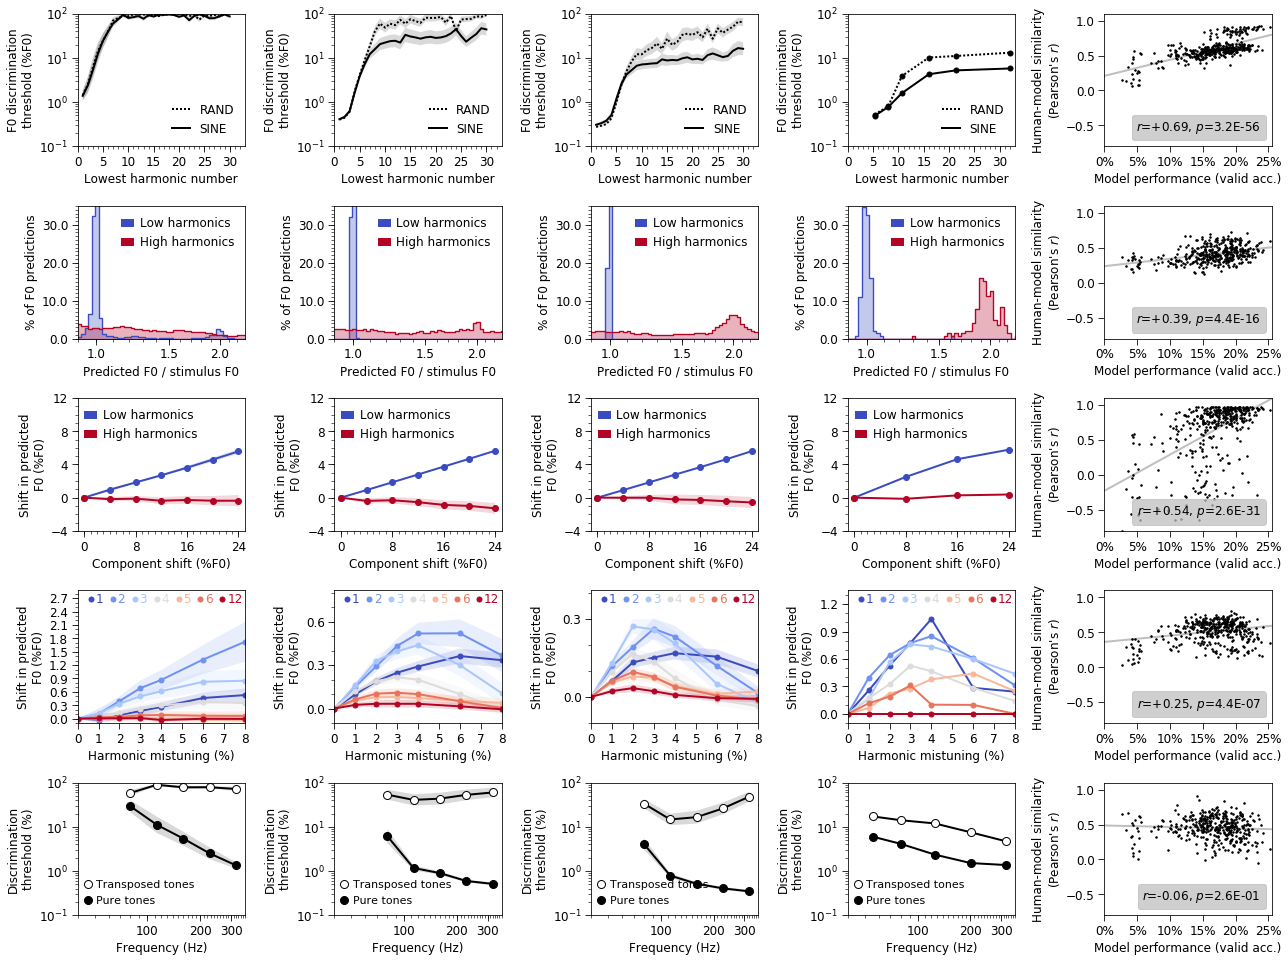

/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2020_04_28_pitchnet_paper_figures_v01/psychophysics_human_model_correlation.pdf


In [6]:
importlib.reload(util_figures)
importlib.reload(util_figures_psychophysics)
importlib.reload(util_human_model_comparison)

sort_idx = np.flip(np.argsort(list_valid_metric))

sorted_list_valid_metric = np.array(list_valid_metric)[sort_idx]
sorted_list_model_dir = np.array(list_model_dir)[sort_idx]
sorted_list_results_dicts = np.array(list_results_dicts)[sort_idx]

experiment_to_plot_fcn_map = {
    'bernox2005': util_figures_psychophysics.make_bernox_threshold_plot,
    'transposedtones': util_figures_psychophysics.make_TT_threshold_plot,
    'freqshiftedcomplexes': util_figures_psychophysics.make_freqshiftedcomplexes_plot,
    'mistunedharmonics': util_figures_psychophysics.make_mistuned_harmonics_line_plot,
    'altphasecomplexes': util_figures_psychophysics.make_altphase_histogram_plot,
}

list_partition = [
    (2*176, 2*176+40),
    (176, 176+40),
    (0, 40),
    'HUMAN',
    'COMPARE',
]

experiment_keys = [
    'bernox2005',
    'altphasecomplexes',
    'freqshiftedcomplexes',
    'mistunedharmonics',
    'transposedtones',
]


NROWS = len(experiment_keys)
NCOLS = len(list_partition)
figsize = (4*NCOLS*0.9, 3*NROWS*0.9)
gridspec_kw = {}
fig, ax = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=figsize, gridspec_kw=gridspec_kw)
ax = ax.reshape([NROWS, NCOLS])

for c_idx, partition in enumerate(list_partition):
    for r_idx, key in enumerate(experiment_keys):
        flag_comparison_plot = False
        if isinstance(partition, str):
            flag_comparison_plot = 'comp' in partition.lower()
            results_dict_input = experiment_to_human_results_map[key]
        else:
            results_dict_input = []
            for idx in range(*partition):
                results_dict_input.append(sorted_list_results_dicts[idx][key])
        
        if flag_comparison_plot:
            make_human_model_comparison_plot(ax[r_idx, c_idx],
                                             list_valid_metric,
                                             dict_list_human_model_comparison[key])
        
        else:
            plot_fcn = experiment_to_plot_fcn_map[key]
            kwargs = {
                'include_yerr': True,
            }
            if isinstance(partition, str) and ('human' in partition.lower()):
                kwargs['include_yerr'] = False
            plot_fcn(ax[r_idx, c_idx], results_dict_input, **kwargs)

plt.tight_layout()
plt.show()


# save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2020_04_28_pitchnet_paper_figures_v01/'
# save_fn = os.path.join(save_dir, 'psychophysics_human_model_correlation.pdf')
# fig.savefig(save_fn, bbox_inches='tight', pad_inches=0.1, transparent=False)
# print(save_fn)


0.6878069128895092 3.2204453312915675e-56
0.3949048672549673 4.422239544043439e-16
0.5419579085588675 2.6316685904453866e-31
0.25175929056482993 4.4126640094889924e-07
-0.05662021633851248 0.2634216041062758


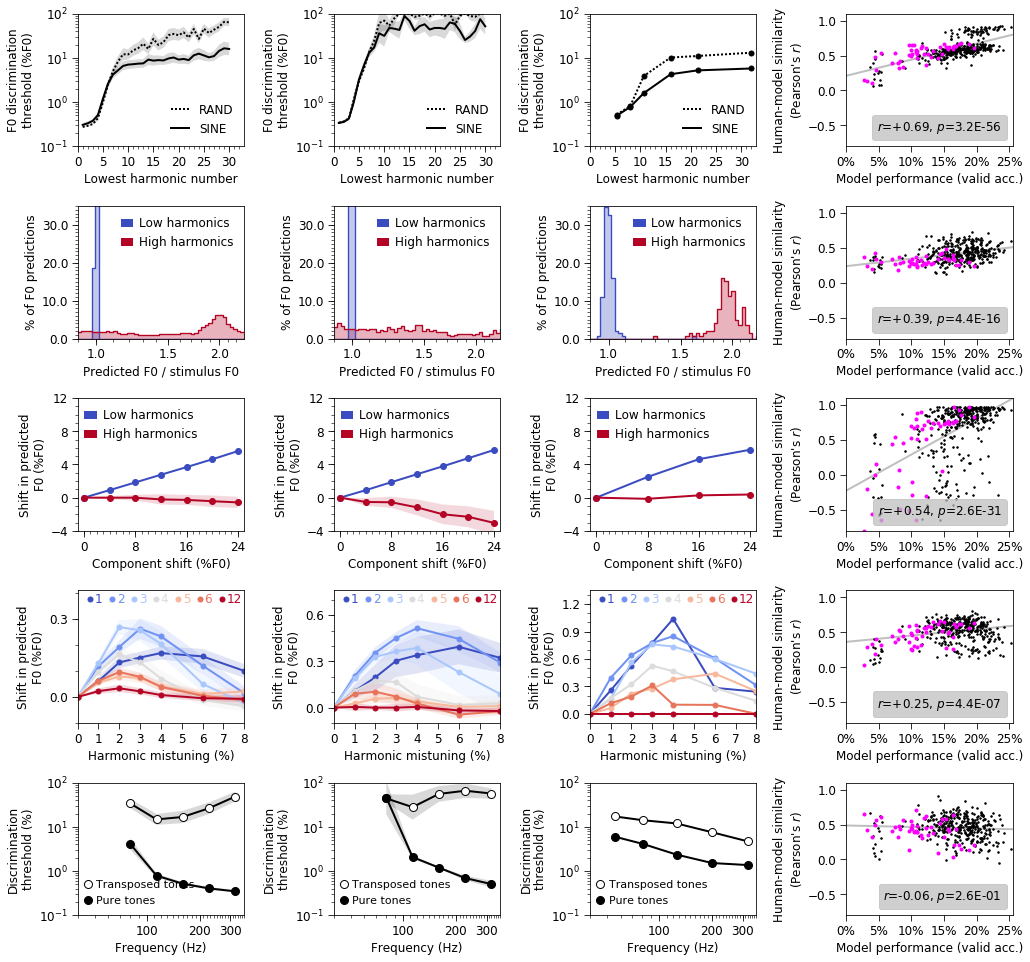

/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2020_04_28_pitchnet_paper_figures_v01/psychophysics_human_model_correlation_accent1layer.pdf


In [7]:
importlib.reload(util_figures)
importlib.reload(util_figures_psychophysics)
importlib.reload(util_human_model_comparison)

sort_idx = np.flip(np.argsort(list_valid_metric))
sorted_list_valid_metric = np.array(list_valid_metric)[sort_idx]
sorted_list_arch_metric = np.array(list_arch_metric)[sort_idx]
sorted_list_model_dir = np.array(list_model_dir)[sort_idx]
sorted_list_results_dicts = np.array(list_results_dicts)[sort_idx]

list_partition = []
list_partition.append(list(range(40)))
for tmp in [1]:#range(1,9):
    filt_idx = np.arange(0, len(sorted_list_arch_metric))
    filt_idx = filt_idx[np.array(sorted_list_arch_metric) == tmp]
    list_partition.append(filt_idx[:5].tolist())
list_partition.append('HUMAN')
list_partition.append('COMPARE')


experiment_to_plot_fcn_map = {
    'bernox2005': util_figures_psychophysics.make_bernox_threshold_plot,
    'transposedtones': util_figures_psychophysics.make_TT_threshold_plot,
    'freqshiftedcomplexes': util_figures_psychophysics.make_freqshiftedcomplexes_plot,
    'mistunedharmonics': util_figures_psychophysics.make_mistuned_harmonics_line_plot,
    'altphasecomplexes': util_figures_psychophysics.make_altphase_histogram_plot,
}


experiment_keys = [
    'bernox2005',
    'altphasecomplexes',
    'freqshiftedcomplexes',
    'mistunedharmonics',
    'transposedtones',
]


NROWS = len(experiment_keys)
NCOLS = len(list_partition)
figsize = (4*NCOLS*0.9, 3*NROWS*0.9)
gridspec_kw = {}
fig, ax = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=figsize, gridspec_kw=gridspec_kw)
ax = ax.reshape([NROWS, NCOLS])

for c_idx, partition in enumerate(list_partition):
    for r_idx, key in enumerate(experiment_keys):
        flag_comparison_plot = False
        if isinstance(partition, str):
            flag_comparison_plot = 'comp' in partition.lower()
            results_dict_input = experiment_to_human_results_map[key]
        elif isinstance(partition, int):
            results_dict_input = sorted_list_results_dicts[partition][key]
        elif isinstance(partition, list):
            results_dict_input = []
            for idx in partition:
                results_dict_input.append(sorted_list_results_dicts[idx][key])
        else:
            results_dict_input = []
            for idx in range(*partition):
                results_dict_input.append(sorted_list_results_dicts[idx][key])
        
        if flag_comparison_plot:
            make_human_model_comparison_plot(ax[r_idx, c_idx],
                                             list_valid_metric,
                                             dict_list_human_model_comparison[key],
                                             accent_indexes=np.array(list_arch_metric)==1,
                                             accent_color='magenta',
                                             accent_markersize=6)
        
        else:
            plot_fcn = experiment_to_plot_fcn_map[key]
            kwargs = {
                'include_yerr': True,
            }
            if isinstance(partition, str) and ('human' in partition.lower()):
                kwargs['include_yerr'] = False
            plot_fcn(ax[r_idx, c_idx], results_dict_input, **kwargs)

plt.tight_layout()
plt.show()

# save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2020_04_28_pitchnet_paper_figures_v01/'
# save_fn = os.path.join(save_dir, 'psychophysics_human_model_correlation_accent1layer.pdf')
# fig.savefig(save_fn, bbox_inches='tight', pad_inches=0.1, transparent=False)
# print(save_fn)


In [ ]:
import scipy.stats
correlation, pvalue = scipy.stats.spearmanr(list_valid_metric, list_f0_error)

plot_kwargs = {
    'marker': '.',
    'ms': 3,
    'ls': '',
    'color': 'k'
}

fig, ax_arr = plt.subplots(nrows=1, ncols=2, figsize=(6, 2.5), sharey=True)

ax_arr[0].set_yticks(np.arange(0.5, 1.2, 0.05), minor=True)
ax_arr[0].set_yticks(np.arange(0.5, 1.2, 0.1), minor=False)
ax_arr[0].grid(color='k', linestyle='-', linewidth=0.1, which='both')
ax_arr[0].plot(list_valid_metric, list_f0_error, **plot_kwargs, label='r={:.3f}'.format(correlation))
ax_arr[0].set_ylim([0.5, 1.2])
ax_arr[0].set_xlim([0.1, 0.26])
ax_arr[0].set_ylabel('Median f0 error (%)')
ax_arr[0].set_xlabel('Validation accuracy')
ax_arr[0].legend(loc='upper right')

sort_idx = np.argsort(list_f0_error)
ax_arr[1].set_yticks(np.arange(0.5, 1.2, 0.05), minor=True)
ax_arr[1].set_yticks(np.arange(0.5, 1.2, 0.1), minor=False)
ax_arr[1].grid(color='k', linestyle='-', linewidth=0.1, which='both')
ax_arr[1].plot(np.arange(0, len(sort_idx)), np.array(list_f0_error)[sort_idx], **plot_kwargs)
ax_arr[1].set_xlabel('Model rank')

plt.show()

# save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2019_12_19_arch_hyperparam_analysis/'
# fig.savefig(os.path.join(save_dir, '2019DEC11_arch_search_v01_arch_0302_manipulations_validAcc_vs_medianF0Error.pdf'), bbox_inches='tight')


In [ ]:
fontsize_labels = 12
fontsize_ticks = 12
plot_kwargs = {
    'marker': '.',
    'ms': 3,
    'ls': '',
    'color': 'k'
}

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 2))

ylimits = [0.5, 10.0]
xlimits = [0, len(sort_idx)-1]
ax.set_xlim(xlimits)
ax.set_ylim(ylimits)
ax.set_yscale('log')
yticks_major = [0.5, 1.0, 5.0, 10.0]

sort_idx = np.argsort(list_f0_error)
ax.set_yticks(yticks_major)
ax.set_yticklabels(yticks_major)
ax.tick_params(axis='both', labelsize=fontsize_ticks)
ax.set_ylabel('Median F0 error (%)', fontsize=fontsize_labels)
ax.set_xlabel('Model rank', fontsize=fontsize_labels)

ax.grid(color='k', linestyle='-', linewidth=0.1, which='both')
ax.plot(np.arange(0, len(sort_idx)), np.array(list_f0_error)[sort_idx], **plot_kwargs)

y1 = [ylimits[0], ylimits[0]]
y2 = [ylimits[1], ylimits[1]]
for xshadelim in [(0,40), (176, 216), (352,392)]:
    ax.fill_between(xshadelim, y1, y2, color='k', alpha=0.10)

plt.show()


# save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2020_02_03_pitchnet_paper_figures/'
# save_fn = os.path.join(save_dir, 'arch_search_v01___model_ranking_by_median_f0_error.pdf')
# fig.savefig(save_fn, bbox_inches='tight')
# print(save_fn)

In [ ]:
### ARCHITECTURE SEARCH : bernox2005 ###

import sys
import os
import json
import numpy as np
import glob
%matplotlib inline
import matplotlib.pyplot as plt

import util_human_model_comparison
human_results_dict = util_human_model_comparison.get_human_results_dict_bernox2005(average_conditions=True)


def load_results_dict(results_dict_fn, pop_key_list=['psychometric_function']):
    with open(results_dict_fn) as f: results_dict = json.load(f)
    for pop_key in pop_key_list:
        if pop_key in results_dict.keys():
            results_dict.pop(pop_key)
    return results_dict

def calc_best_metric(valid_metrics_fn, metric_key='f0_label:accuracy', maximize=True):
    with open(valid_metrics_fn) as f: valid_metrics_dict = json.load(f)
    metric_values = valid_metrics_dict[metric_key]
    if maximize: best_metric_value = np.max(metric_values)
    else: best_metric_value = np.min(metric_values)
    return best_metric_value

def calc_num_layers(brain_arch_fn):
    with open(brain_arch_fn) as f: brain_arch = json.load(f)
    num_conv_layers = 0
    for layer_dict in brain_arch:
        if layer_dict['layer_type'] == 'tf.layers.conv2d':
            num_conv_layers = num_conv_layers + 1
    return num_conv_layers


# results_dict_regex = '/om/scratch/Sat/msaddler/pitchnet/saved_models/IHC0050Hz_arch_search_v01_arch_0302_manipulations/arch_*/EVAL_SOFTMAX_bernox2005_FixedFilter_bestckpt_results_dict.json'
results_dict_regex = '/om/scratch/*/msaddler/pitchnet/saved_models/arch_search_v01_arch_0302_manipulations_v01/arch_*/EVAL_SOFTMAX_bernox2005_FixedFilter_bestckpt_results_dict.json'

results_dict_fn_list = sorted(glob.glob(results_dict_regex))
valid_dict_fn_list = []
arch_dict_fn_list = []
for fn in results_dict_fn_list:
    output_dir, _ = os.path.split(fn)
    valid_dict_fn_list.append(os.path.join(output_dir, 'validation_metrics.json'))
    arch_dict_fn_list.append(os.path.join(output_dir, 'brain_arch.json'))

results_dict_list = []
valid_metric_list = []
arch_stat_list = []
human_comparison_metric_list = []
for idx, (rdfn, vfn, afn) in enumerate(zip(results_dict_fn_list, valid_dict_fn_list, arch_dict_fn_list)):
    if idx % 50 == 0: print(idx)
    results_dict = load_results_dict(rdfn)
    results_dict_list.append(results_dict)
    valid_metric_list.append(calc_best_metric(vfn))
    arch_stat_list.append(calc_num_layers(afn))
    
    (corr_value, pval) = util_human_model_comparison.compare_bernox2005(
        human_results_dict, results_dict,
        kwargs_interp={}, kwargs_compare={'log_scale':True, 'metric':'spearmanr'})
    
    human_comparison_metric_list.append(corr_value)
    

print(len(results_dict_list))


In [ ]:
import scipy.stats

correlation, pvalue = scipy.stats.pearsonr(valid_metric_list, human_comparison_metric_list)

val_metrics = np.array(valid_metric_list)
hum_metrics = np.array(human_comparison_metric_list)
arc_metrics = np.array(arch_stat_list)

unique_arc_metrics = np.unique(arc_metrics)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))

for current_arc_metric in unique_arc_metrics:
    IDX = arc_metrics == current_arc_metric
    label = '{} conv layers'.format(current_arc_metric)
    ax.plot(val_metrics[IDX], hum_metrics[IDX], ls='', marker='.', markersize=6, label=label)

ax.set_xlabel('validation_accuracy')
ax.set_ylabel('model-human comparison metric (spearmanr)')
ax.set_title('Spearman correlation coefficient R={:.04f}'.format(correlation))
ax.legend(ncol=2, loc='lower right', markerscale=3)

plt.tight_layout()
plt.show()

# fig.savefig('figures/archive_2019_12_05_PNDv08_archSearch01/2019DEC04_arch_search_v01_bernox2005_NetworkHumanCorrelation.pdf', bbox_inches='tight')


In [ ]:
### MAKE PLOTS : bernox2005 ###

tmp_valid_metric_list = valid_metric_list.copy()
tmp_arch_stat_list = arch_stat_list.copy()
sort_idx = np.flip(np.argsort(valid_metric_list)).tolist()
sort_idx = np.arange(0, len(valid_metric_list))
# sort_idx = np.flip(np.argsort(human_comparison_metric_list)).tolist()

model_idx_list = []
for idx in sort_idx:
    if True:#tmp_arch_stat_list[idx] == 9: #human_comparison_metric_list[idx] < 0.9:#tmp_arch_stat_list[idx] == 6:
        model_idx_list.append(idx)
        
model_idx_list = model_idx_list[:]
print('generating {} plots'.format(len(model_idx_list)))

#for idx in model_idx_list: print(arch_dict_fn_list[idx])


def make_threshold_plot(ax, results_dict, title_str=None, legend_on=True,
                        sine_plot_kwargs={}, rand_plot_kwargs={},
                        xlabel='Lowest harmonic number',
                        ylabel='F0 discrimination threshold (%F0)'):
    phase_mode_list = np.array(results_dict['phase_mode'])
    low_harm_list = np.array(results_dict['low_harm'])
    f0dl_list = np.array(results_dict['f0dl'])
    CAP = 100.0
    f0dl_list[f0dl_list > CAP] = CAP
    unique_phase_modes = np.unique(phase_mode_list)
    for phase_mode in unique_phase_modes:
        x = low_harm_list[phase_mode_list == phase_mode]
        y = f0dl_list[phase_mode_list == phase_mode]
        
        if phase_mode == 0:
            plot_kwargs = {'label': 'sine', 'color': 'b', 'ls':'-', 'lw':2, 'ms':8, 'marker':''}
            plot_kwargs.update(sine_plot_kwargs)
        else:
            plot_kwargs = {'label': 'rand', 'color': 'b', 'ls':'--', 'lw':2, 'ms':8, 'marker':''}
            plot_kwargs.update(rand_plot_kwargs)
        
        if not legend_on: plot_kwargs['label'] = None
        ax.plot(x, y, **plot_kwargs)

    ax.set_yscale('log')
    ax.set_ylim([1e-1, 3e2])
    ax.set_xlim([0, 32])
    ax.set_xlabel(xlabel, fontsize=10)
    ax.set_ylabel(ylabel, fontsize=10)
    if title_str is not None: ax.set_title(title_str, fontsize=10)
    if legend_on: ax.legend(loc='lower right', frameon=False, fontsize=10)



NCOLS = 6
NROWS = int(np.ceil(len(model_idx_list) / NCOLS))
fig, ax_arr = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(0.75*4*NCOLS, 0.75*3*NROWS))
ax_arr = ax_arr.flatten()

for ax_idx, model_idx in enumerate(model_idx_list):
    
    results_dict = results_dict_list[model_idx]
    
    title_str = 'valid_acc={:.4f}. n_layers={:d},\nhuman_comparison_metric={:.3f}'.format(
        valid_metric_list[model_idx],
        arch_stat_list[model_idx],
        human_comparison_metric_list[model_idx])
    
    ax = ax_arr[ax_idx]
    make_threshold_plot(ax, human_results_dict, title_str=None, legend_on=False,
                        sine_plot_kwargs={'color':'r', 'lw':0.5}, rand_plot_kwargs={'color':'r', 'lw':0.5})
    make_threshold_plot(ax, results_dict, title_str=title_str, legend_on=True,
                        sine_plot_kwargs={'color':'k', 'lw':2}, rand_plot_kwargs={'color':'b', 'lw':2},
                        ylabel='F0DL (%F0)')

for ax_idx in range(len(model_idx_list), len(ax_arr)): ax_arr[ax_idx].axis('off')

plt.tight_layout()
plt.show()

# save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2019_12_19_arch_hyperparam_analysis/'
# fig.savefig(os.path.join(save_dir, '2019DEC20_IHC0050Hz_arch_search_v01_arch_0302_manipulations_bernox2005_sortedByValidAcc.pdf'), bbox_inches='tight')


In [ ]:
### ARCHITECTURE SEARCH : transposed tones ###

import sys
import os
import json
import numpy as np
import glob
%matplotlib inline
import matplotlib.pyplot as plt

import util_human_model_comparison
human_results_dict = util_human_model_comparison.get_human_results_dict_transposedtones()


def load_results_dict(results_dict_fn, pop_key_list=['psychometric_function']):
    with open(results_dict_fn) as f: results_dict = json.load(f)
    for pop_key in pop_key_list:
        if pop_key in results_dict.keys():
            results_dict.pop(pop_key)
    return results_dict

def calc_best_metric(valid_metrics_fn, metric_key='f0_label:accuracy', maximize=True):
    with open(valid_metrics_fn) as f: valid_metrics_dict = json.load(f)
    metric_values = valid_metrics_dict[metric_key]
    if maximize: best_metric_value = np.max(metric_values)
    else: best_metric_value = np.min(metric_values)
    return best_metric_value

def calc_num_layers(brain_arch_fn):
    with open(brain_arch_fn) as f: brain_arch = json.load(f)
    num_conv_layers = 0
    for layer_dict in brain_arch:
        if layer_dict['layer_type'] == 'tf.layers.conv2d':
            num_conv_layers = num_conv_layers + 1
    return num_conv_layers


# results_dict_regex = '/om/scratch/Sat/msaddler/pitchnet/saved_models/arch_search_v01_arch_0302_manipulations/arch_*/EVAL_SOFTMAX_oxenham2004_080to320Hz_bestckpt_results_dict.json'
results_dict_regex = '/om/scratch/*/msaddler/pitchnet/saved_models/arch_search_v01_arch_0302_manipulations_v01/arch_*/EVAL_SOFTMAX_oxenham2004_080to320Hz_bestckpt_results_dict.json'

results_dict_fn_list = sorted(glob.glob(results_dict_regex))
valid_dict_fn_list = []
arch_dict_fn_list = []
for fn in results_dict_fn_list:
    output_dir, _ = os.path.split(fn)
    valid_dict_fn_list.append(os.path.join(output_dir, 'validation_metrics.json'))
    arch_dict_fn_list.append(os.path.join(output_dir, 'brain_arch.json'))

results_dict_list = []
valid_metric_list = []
arch_stat_list = []
human_comparison_metric_list = []
for idx, (rdfn, vfn, afn) in enumerate(zip(results_dict_fn_list, valid_dict_fn_list, arch_dict_fn_list)):
    results_dict = load_results_dict(rdfn)
    results_dict_list.append(results_dict)
    valid_metric_list.append(calc_best_metric(vfn))
    arch_stat_list.append(calc_num_layers(afn))
    
    (corr_value, pval) = util_human_model_comparison.compare_transposedtones(
        human_results_dict, results_dict,
        kwargs_interp={}, kwargs_compare={'log_scale':True, 'metric':'spearmanr'})
    
    human_comparison_metric_list.append(corr_value)
    

print(len(results_dict_list))


In [ ]:
import scipy.stats

correlation, pvalue = scipy.stats.pearsonr(valid_metric_list, human_comparison_metric_list)

val_metrics = np.array(valid_metric_list)
hum_metrics = np.array(human_comparison_metric_list)
arc_metrics = np.array(arch_stat_list)

unique_arc_metrics = np.unique(arc_metrics)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))

for current_arc_metric in unique_arc_metrics:
    IDX = arc_metrics == current_arc_metric
    label = '{} conv layers'.format(current_arc_metric)
    ax.plot(val_metrics[IDX], hum_metrics[IDX], ls='', marker='.', markersize=6, label=label)

ax.set_xlabel('validation_accuracy')
ax.set_ylabel('model-human comparison metric (spearmanr)')
ax.set_title('Spearman correlation coefficient R={:.04f}'.format(correlation))
ax.legend(ncol=2, loc='lower right', markerscale=3)

plt.tight_layout()
plt.show()

# fig.savefig('figures/archive_2019_12_05_PNDv08_archSearch01/2019DEC05_arch_search_v01_TransposedTones_NetworkHumanCorrelation.pdf', bbox_inches='tight')


In [ ]:
### MAKE PLOTS : transposed tones ###

tmp_valid_metric_list = valid_metric_list.copy()
tmp_arch_stat_list = arch_stat_list.copy()
sort_idx = np.flip(np.argsort(valid_metric_list)).tolist()
sort_idx = np.arange(0, len(valid_metric_list))
# sort_idx = np.flip(np.argsort(human_comparison_metric_list)).tolist()

model_idx_list = []
for idx in sort_idx:
    if True:#tmp_arch_stat_list[idx] == 9: #human_comparison_metric_list[idx] < 0.9:#tmp_arch_stat_list[idx] == 6:
        model_idx_list.append(idx)
        
model_idx_list = model_idx_list[:]
print('generating {} plots'.format(len(model_idx_list)))


def make_TT_threshold_plot(ax, results_dict, title_str=None, legend_on=True):
    f0_ref = np.array(results_dict['f0_ref'])
    f_carrier_list = np.array(results_dict['f_carrier'])
    f0dl_list = np.array(results_dict['f0dl'])
    unique_f_carrier_list = np.unique(f_carrier_list)
    for f_carrier in unique_f_carrier_list:
        x = f0_ref[f_carrier_list == f_carrier]
        y = f0dl_list[f_carrier_list == f_carrier]
        
        if f_carrier > 0:
            label = '{}-Hz TT'.format(int(f_carrier))
            plot_kwargs = {'label': label, 'color': 'k', 'ls':'-', 'lw':2, 'ms':6,
                           'marker':'o', 'markerfacecolor': 'w'}
            if int(f_carrier) == 10080: plot_kwargs['marker'] = 'D'
            if int(f_carrier) == 6350: plot_kwargs['marker'] = '^'
            if int(f_carrier) == 4000: plot_kwargs['marker'] = 's'
        else:
            label = 'Pure tone'
            plot_kwargs = {'label': label, 'color': 'k', 'ls':'-', 'lw':2, 'ms':6,
                           'marker':'o', 'markerfacecolor': 'k'}
            
        if not legend_on: plot_kwargs['label'] = None
        ax.plot(x, y, **plot_kwargs)

    ax.set_yscale('log')
    ax.set_ylim([5e-1, 3e1])
    ax.set_xscale('log')
    ax.set_xlim([40, 500])
    ax.set_xlabel('Frequency (Hz)', fontsize=10)
    ax.set_ylabel('Frequency difference (%)', fontsize=10)
    if title_str is not None: ax.set_title(title_str, fontsize=10)
    if legend_on: ax.legend(loc='lower left', frameon=False, fontsize=8, handlelength=0)


        
NCOLS = 6
NROWS = int(np.ceil(len(model_idx_list) / NCOLS))
fig, ax_arr = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(0.75*4*NCOLS, 0.75*3*NROWS))
ax_arr = ax_arr.flatten()

for ax_idx, model_idx in enumerate(model_idx_list):
    
    results_dict = results_dict_list[model_idx]
    
    title_str = 'valid_acc={:.4f}. n_layers={:d},\nhuman_comparison_metric={:.3f}'.format(
        valid_metric_list[model_idx],
        arch_stat_list[model_idx],
        human_comparison_metric_list[model_idx])
    
    ax = ax_arr[ax_idx]
    make_TT_threshold_plot(ax, results_dict, title_str=title_str, legend_on=True)

for ax_idx in range(len(model_idx_list), len(ax_arr)): ax_arr[ax_idx].axis('off')

plt.tight_layout()
plt.show()

# save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2019_12_19_arch_hyperparam_analysis/'
# fig.savefig(os.path.join(save_dir, '2019DEC11_arch_search_v01_arch_0302_manipulations_transposedtones_sortedByValidAcc.pdf'), bbox_inches='tight')


In [ ]:
### ARCHITECTURE SEARCH : freq-shifted complexes ###

import sys
import os
import json
import numpy as np
import glob
%matplotlib inline
import matplotlib.pyplot as plt

import importlib
import util_human_model_comparison
import util_psychophysics_figures
importlib.reload(util_psychophysics_figures)

human_results_dict = util_human_model_comparison.get_human_results_dict_freqshiftedcomplexes()


def load_results_dict(results_dict_fn, pop_key_list=['psychometric_function']):
    with open(results_dict_fn) as f: results_dict = json.load(f)
    for pop_key in pop_key_list:
        if pop_key in results_dict.keys():
            results_dict.pop(pop_key)
    return results_dict

def calc_best_metric(valid_metrics_fn, metric_key='f0_label:accuracy', maximize=True):
    with open(valid_metrics_fn) as f: valid_metrics_dict = json.load(f)
    metric_values = valid_metrics_dict[metric_key]
    if maximize: best_metric_value = np.max(metric_values)
    else: best_metric_value = np.min(metric_values)
    return best_metric_value

def calc_num_layers(brain_arch_fn):
    with open(brain_arch_fn) as f: brain_arch = json.load(f)
    num_conv_layers = 0
    for layer_dict in brain_arch:
        if layer_dict['layer_type'] == 'tf.layers.conv2d':
            num_conv_layers = num_conv_layers + 1
    return num_conv_layers


results_dict_regex = '/om/scratch/Sat/msaddler/pitchnet/saved_models/arch_search_v01_arch_0302_manipulations/arch_*/EVAL_SOFTMAX_mooremoore2003_080to480Hz_bestckpt_results_dict.json'
results_dict_fn_list = sorted(glob.glob(results_dict_regex))
valid_dict_fn_list = []
arch_dict_fn_list = []
for fn in results_dict_fn_list:
    output_dir, _ = os.path.split(fn)
    valid_dict_fn_list.append(os.path.join(output_dir, 'validation_metrics.json'))
    arch_dict_fn_list.append(os.path.join(output_dir, 'brain_arch.json'))

results_dict_list = []
valid_metric_list = []
arch_stat_list = []
human_comparison_metric_list = []
for idx, (rdfn, vfn, afn) in enumerate(zip(results_dict_fn_list, valid_dict_fn_list, arch_dict_fn_list)):
    results_dict = load_results_dict(rdfn)
    results_dict_list.append(results_dict)
    valid_metric_list.append(calc_best_metric(vfn))
    arch_stat_list.append(calc_num_layers(afn))
    
    (corr_value, pval) = util_human_model_comparison.compare_freqshiftedcomplexes(
        human_results_dict, results_dict,
        kwargs_interp={}, kwargs_compare={'log_scale':False, 'metric':'pearsonr'})
    
    human_comparison_metric_list.append(corr_value)
    

print(len(results_dict_list))


In [ ]:
import scipy.stats

correlation, pvalue = scipy.stats.pearsonr(valid_metric_list, human_comparison_metric_list)

val_metrics = np.array(valid_metric_list)
hum_metrics = np.array(human_comparison_metric_list)
arc_metrics = np.array(arch_stat_list)

unique_arc_metrics = np.unique(arc_metrics)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))

for current_arc_metric in unique_arc_metrics:
    IDX = arc_metrics == current_arc_metric
    label = '{} conv layers'.format(current_arc_metric)
    ax.plot(val_metrics[IDX], hum_metrics[IDX], ls='', marker='.', markersize=6, label=label)

ax.set_xlabel('validation_accuracy')
ax.set_ylabel('model-human comparison metric (spearmanr)')
ax.set_title('Spearman correlation coefficient R={:.04f}'.format(correlation))
ax.legend(ncol=2, loc='lower right', markerscale=3)

plt.tight_layout()
plt.show()

# fig.savefig('figures/archive_2019_12_05_PNDv08_archSearch01/2019DEC05_arch_search_v01_FreqShifted_NetworkHumanCorrelation.pdf', bbox_inches='tight')


In [ ]:
### MAKE PLOTS : freq-shifted complexes ###

tmp_valid_metric_list = valid_metric_list.copy()
tmp_arch_stat_list = arch_stat_list.copy()
sort_idx = np.flip(np.argsort(valid_metric_list)).tolist()
# sort_idx = np.flip(np.argsort(human_comparison_metric_list)).tolist()

model_idx_list = []
for idx in sort_idx:
    if True:#tmp_arch_stat_list[idx] == 9: #human_comparison_metric_list[idx] < 0.9:#tmp_arch_stat_list[idx] == 6:
        model_idx_list.append(idx)
        
model_idx_list = model_idx_list[:]
print('generating {} plots'.format(len(model_idx_list)))


# def make_freqshiftedcomplexes_plot(ax, results_dict, title_str=None, legend_on=True):
#     key_to_label_map={5:'RES', 11:'INT', 16:'UNRES'}
#     filter_key='spectral_envelope_centered_harmonic'
#     for key in sorted(results_dict[filter_key].keys()):
#         xval = results_dict[filter_key][key]['f0_shift']
#         yval = results_dict[filter_key][key]['f0_pred_shift_median']
#         yerr = results_dict[filter_key][key]['f0_pred_shift_stddev']
#         ax.plot(xval, yval, '.-', label=key_to_label_map.get(key, key))

#     if legend_on: ax.legend(loc=2, frameon=False, fontsize=10)
#     if title_str: ax.set_title(title_str, fontsize=10)
#     ax.set_xlabel('Component shift (%F0)', fontsize=10)
#     ax.set_ylabel('Shift in pred F0 (%F0)', fontsize=10)
#     ax.set_xlim([-0.5, 24.5])
#     ax.set_ylim([-4, 12])



NCOLS = 6
NROWS = int(np.ceil(len(model_idx_list) / NCOLS))
fig, ax_arr = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(0.75*4*NCOLS, 0.75*3*NROWS))
ax_arr = ax_arr.flatten()

for ax_idx, model_idx in enumerate(model_idx_list):
    
    results_dict = results_dict_list[model_idx]
    
    title_str = 'valid_acc={:.4f}. n_layers={:d},\nhuman_comparison_metric={:.3f}'.format(
        valid_metric_list[model_idx],
        arch_stat_list[model_idx],
        human_comparison_metric_list[model_idx])
    
    ax = ax_arr[ax_idx]
#     make_freqshiftedcomplexes_plot(ax, results_dict, title_str=title_str, legend_on=True)
    util_psychophysics_figures.make_freqshiftedcomplexes_plot(ax, results_dict,
                                                              use_relative_shift=True,
                                                              title_str=title_str,
                                                              legend_on=True,
                                                              fontsize_title=10,
                                                              fontsize_labels=10,
                                                              fontsize_legend=8,
                                                              fontsize_ticks=8)

for ax_idx in range(len(model_idx_list), len(ax_arr)): ax_arr[ax_idx].axis('off')

plt.tight_layout()
plt.show()

# save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2019_12_19_arch_hyperparam_analysis/'
# fig.savefig(os.path.join(save_dir, '2019DEC11_arch_search_v01_arch_0302_manipulations_freqshifted_sortedByValidAcc.pdf'), bbox_inches='tight')


In [ ]:
### ARCHITECTURE SEARCH : mistuned harmonics ###

import sys
import os
import json
import numpy as np
import glob
%matplotlib inline
import matplotlib.pyplot as plt

import util_human_model_comparison
human_results_dict = util_human_model_comparison.get_human_results_dict_mistunedharmonics()


def load_results_dict(results_dict_fn, pop_key_list=['psychometric_function']):
    with open(results_dict_fn) as f: results_dict = json.load(f)
    for pop_key in pop_key_list:
        if pop_key in results_dict.keys():
            results_dict.pop(pop_key)
    return results_dict

def calc_best_metric(valid_metrics_fn, metric_key='f0_label:accuracy', maximize=True):
    with open(valid_metrics_fn) as f: valid_metrics_dict = json.load(f)
    metric_values = valid_metrics_dict[metric_key]
    if maximize: best_metric_value = np.max(metric_values)
    else: best_metric_value = np.min(metric_values)
    return best_metric_value

def calc_num_layers(brain_arch_fn):
    with open(brain_arch_fn) as f: brain_arch = json.load(f)
    num_conv_layers = 0
    for layer_dict in brain_arch:
        if layer_dict['layer_type'] == 'tf.layers.conv2d':
            num_conv_layers = num_conv_layers + 1
    return num_conv_layers


results_dict_regex = '/om/scratch/Sat/msaddler/pitchnet/saved_models/arch_search_v01_arch_0302_manipulations/arch_*/EVAL_SOFTMAX_MistunedHarm_v00_bestckpt_results_dict.json'
results_dict_fn_list = sorted(glob.glob(results_dict_regex))
valid_dict_fn_list = []
arch_dict_fn_list = []
for fn in results_dict_fn_list:
    output_dir, _ = os.path.split(fn)
    valid_dict_fn_list.append(os.path.join(output_dir, 'validation_metrics.json'))
    arch_dict_fn_list.append(os.path.join(output_dir, 'brain_arch.json'))

results_dict_list = []
valid_metric_list = []
arch_stat_list = []
human_comparison_metric_list = []
for idx, (rdfn, vfn, afn) in enumerate(zip(results_dict_fn_list, valid_dict_fn_list, arch_dict_fn_list)):
    results_dict = load_results_dict(rdfn)
    results_dict_list.append(results_dict)
    valid_metric_list.append(calc_best_metric(vfn))
    arch_stat_list.append(calc_num_layers(afn))
    
    (corr_value, pval) = util_human_model_comparison.compare_mistunedharmonics(
        human_results_dict, results_dict,
        kwargs_bar_graph={}, kwargs_compare={'log_scale':False, 'metric':'pearsonr'})
    
    human_comparison_metric_list.append(corr_value)
    

print(len(results_dict_list))


In [ ]:
import scipy.stats

correlation, pvalue = scipy.stats.pearsonr(valid_metric_list, human_comparison_metric_list)

val_metrics = np.array(valid_metric_list)
hum_metrics = np.array(human_comparison_metric_list)
arc_metrics = np.array(arch_stat_list)

unique_arc_metrics = np.unique(arc_metrics)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))

for current_arc_metric in unique_arc_metrics:
    IDX = arc_metrics == current_arc_metric
    label = '{} conv layers'.format(current_arc_metric)
    ax.plot(val_metrics[IDX], hum_metrics[IDX], ls='', marker='.', markersize=6, label=label)

ax.set_xlabel('validation_accuracy')
ax.set_ylabel('model-human comparison metric (spearmanr)')
ax.set_title('Spearman correlation coefficient R={:.04f}'.format(correlation))
ax.legend(ncol=2, loc='lower right', markerscale=3)

plt.tight_layout()
plt.show()

# fig.savefig('figures/archive_2019_12_05_PNDv08_archSearch01/2019DEC05_arch_search_v01_MistunedHarmonics_NetworkHumanCorrelation.pdf', bbox_inches='tight')


In [ ]:
### MAKE PLOTS : mistuned harmonics ###

tmp_valid_metric_list = valid_metric_list.copy()
tmp_arch_stat_list = arch_stat_list.copy()
sort_idx = np.flip(np.argsort(valid_metric_list)).tolist()
# sort_idx = np.flip(np.argsort(human_comparison_metric_list)).tolist()

model_idx_list = []
for idx in sort_idx:
    if True:#tmp_arch_stat_list[idx] == 9: #human_comparison_metric_list[idx] < 0.9:#tmp_arch_stat_list[idx] == 6:
        model_idx_list.append(idx)
        
model_idx_list = model_idx_list[:]
print('generating {} plots'.format(len(model_idx_list)))


def make_mistuned_harmonics_bar_graph(ax, results_dict, mistuned_pct=3.0,
                                      pitch_shift_key='f0_pred_pct_median',
                                      title_str=None, legend_on=True, barwidth=0.12):
    '''
    '''
    bar_graph_results_dict = util_human_model_comparison.get_mistuned_harmonics_bar_graph_results_dict(
        results_dict,
        mistuned_pct=mistuned_pct,
        pitch_shift_key=pitch_shift_key,
        harmonic_list=[1,2,3,4,5,6])

    num_groups = len(bar_graph_results_dict.keys())
    group_xoffsets = np.arange(num_groups) - np.mean(np.arange(num_groups))
    
    for group_idx, group_key in enumerate(sorted(bar_graph_results_dict.keys())):
        bars_per_group = len(bar_graph_results_dict[group_key]['f0_ref'])
        xvals = np.arange(bars_per_group)
        yvals = np.array(bar_graph_results_dict[group_key][pitch_shift_key])
        
        xvals = xvals + barwidth*group_xoffsets[group_idx]
        ax.bar(xvals, yvals, width=barwidth, edgecolor='white', label=group_key)

    base_xvals = np.arange(bars_per_group)
    f0_ref_values = bar_graph_results_dict[group_key]['f0_ref']
    
    if title_str: ax.set_title(title_str, fontsize=10)
    if legend_on: ax.legend(loc='upper right', frameon=False, fontsize=8, handlelength=0.5)
    ax.set_xlim([barwidth*group_xoffsets[0]-0.5,
                 np.max(base_xvals) + barwidth*group_xoffsets[-1] + 1])
    ax.set_xlabel('F0 (Hz)')
    ax.set_xticks(base_xvals)
    ax.set_xticklabels(f0_ref_values)



NCOLS = 6
NROWS = int(np.ceil(len(model_idx_list) / NCOLS))
fig, ax_arr = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(0.75*4*NCOLS, 0.75*3*NROWS))
ax_arr = ax_arr.flatten()

for ax_idx, model_idx in enumerate(model_idx_list):
    
    results_dict = results_dict_list[model_idx]
    
    title_str = 'valid_acc={:.4f}. n_layers={:d},\nhuman_comparison_metric={:.3f}'.format(
        valid_metric_list[model_idx],
        arch_stat_list[model_idx],
        human_comparison_metric_list[model_idx])
    
    ax = ax_arr[ax_idx]
    make_mistuned_harmonics_bar_graph(ax, results_dict, mistuned_pct=3.0,
                                      pitch_shift_key='f0_pred_pct_median',
                                      title_str=title_str, legend_on=True, barwidth=0.12)

for ax_idx in range(len(model_idx_list), len(ax_arr)): ax_arr[ax_idx].axis('off')

plt.tight_layout()
plt.show()

# save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2019_12_19_arch_hyperparam_analysis/'
# fig.savefig(os.path.join(save_dir, '2019DEC11_arch_search_v01_arch_0302_manipulations_mistunedharmonics_sortedByValidAcc.pdf'), bbox_inches='tight')


In [ ]:
### ARCHITECTURE SEARCH : alt-phase complexes ###

import sys
import os
import json
import numpy as np
import glob
%matplotlib inline
import matplotlib.pyplot as plt

import util_human_model_comparison
import util_psychophysics_figures
import importlib
importlib.reload(util_human_model_comparison)
importlib.reload(util_psychophysics_figures)
human_results_dict = util_human_model_comparison.get_human_results_dict_altphasecomplexes()


def load_results_dict(results_dict_fn, pop_key_list=['psychometric_function']):
    with open(results_dict_fn) as f: results_dict = json.load(f)
    for pop_key in pop_key_list:
        if pop_key in results_dict.keys():
            results_dict.pop(pop_key)
    return results_dict

def calc_best_metric(valid_metrics_fn, metric_key='f0_label:accuracy', maximize=True):
    with open(valid_metrics_fn) as f: valid_metrics_dict = json.load(f)
    metric_values = valid_metrics_dict[metric_key]
    if maximize: best_metric_value = np.max(metric_values)
    else: best_metric_value = np.min(metric_values)
    return best_metric_value

def calc_num_layers(brain_arch_fn):
    with open(brain_arch_fn) as f: brain_arch = json.load(f)
    num_conv_layers = 0
    for layer_dict in brain_arch:
        if layer_dict['layer_type'] == 'tf.layers.conv2d':
            num_conv_layers = num_conv_layers + 1
    return num_conv_layers


results_dict_regex = '/om/scratch/Wed/msaddler/pitchnet/saved_models/arch_search_v01_arch_0302_manipulations/arch_*/EVAL_SOFTMAX_AltPhase_v01_bestckpt_results_dict.json'
results_dict_regex = '/om/scratch/Wed/msaddler/pitchnet/saved_models/arch_search_v01/arch_*/EVAL_SOFTMAX_AltPhase_v01_bestckpt_results_dict.json'

results_dict_fn_list = sorted(glob.glob(results_dict_regex))
valid_dict_fn_list = []
arch_dict_fn_list = []
for fn in results_dict_fn_list:
    output_dir, _ = os.path.split(fn)
    valid_dict_fn_list.append(os.path.join(output_dir, 'validation_metrics.json'))
    arch_dict_fn_list.append(os.path.join(output_dir, 'brain_arch.json'))

results_dict_list = []
valid_metric_list = []
arch_stat_list = []
human_comparison_metric_list = []
for idx, (rdfn, vfn, afn) in enumerate(zip(results_dict_fn_list, valid_dict_fn_list, arch_dict_fn_list)):
    results_dict = load_results_dict(rdfn)
    results_dict_list.append(results_dict)
    valid_metric_list.append(calc_best_metric(vfn))
    arch_stat_list.append(calc_num_layers(afn))
    
#     corr_value, pval = util_human_model_comparison.compare_altphasecomplexes_line(human_results_dict, results_dict)
#     human_comparison_metric_list.append(corr_value)

    corr_value, pval = util_human_model_comparison.compare_altphasecomplexes_hist(human_results_dict,
                                                                                  results_dict,
                                                                                  restrict_conditions_filter=[125.0, 3900.0],#[125.0, 1375.0, 3900.0],
                                                                                  restrict_conditions_f0=[125.0],
                                                                                  kwargs_compare={'log_scale':False})
    human_comparison_metric_list.append(corr_value)
    
human_comparison_metric_list = np.array(human_comparison_metric_list)
print(human_comparison_metric_list.shape)


# human_comparison_metric_list = -np.mean(human_comparison_metric_list, axis=1)
# human_comparison_metric_list = -np.sqrt(np.sum(np.square(human_comparison_metric_list), axis=1))
# human_comparison_metric_list = -scipy.stats.gmean(human_comparison_metric_list, axis=1)

print(len(results_dict_list))


In [ ]:
import scipy.stats

correlation, pvalue = scipy.stats.spearmanr(valid_metric_list, human_comparison_metric_list)

val_metrics = np.array(valid_metric_list)
hum_metrics = np.array(human_comparison_metric_list)
arc_metrics = np.array(arch_stat_list)

unique_arc_metrics = np.unique(arc_metrics)


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))
ax.set_title('Spearman correlation coefficient R={:.04f}'.format(correlation))
ax.plot(val_metrics, hum_metrics,
        ls='', marker='.', markersize=6, color='k')
plt.show()



# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))

# for current_arc_metric in unique_arc_metrics:
#     IDX = arc_metrics == current_arc_metric
#     label = '{} conv layers'.format(current_arc_metric)
#     ax.plot(val_metrics[IDX], hum_metrics[IDX], ls='', marker='.', markersize=6, label=label)

# ax.set_xlabel('validation_accuracy')
# ax.set_ylabel('model-human comparison metric')
# ax.set_title('Spearman correlation coefficient R={:.04f}'.format(correlation))
# ax.legend(ncol=2, loc='lower right', markerscale=3)

# plt.tight_layout()
# plt.show()

# fig.savefig('figures/archive_2019_12_05_PNDv08_archSearch01/2019DEC05_arch_search_v01_AltPhase_NetworkHumanCorrelation.pdf', bbox_inches='tight')


In [ ]:
import scipy.stats

correlation, pvalue = scipy.stats.spearmanr(valid_metric_list, human_comparison_metric_list)

val_metrics = np.array(valid_metric_list)
hum_metrics = np.array(human_comparison_metric_list)
arc_metrics = np.array(arch_stat_list)

unique_arc_metrics = np.unique(arc_metrics)

x = np.arange(0, 100)
y = np.random.randn(x.shape[0])

# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))
# ax.plot(np.argsort(x), np.argsort(y),
#         ls='', marker='.', markersize=6, color='k')
# plt.show()

np.argsort(x), np.argsort(x)[np.argsort(y)]

In [ ]:
### MAKE PLOTS : alt-phase complexes ###

tmp_valid_metric_list = valid_metric_list.copy()
tmp_arch_stat_list = arch_stat_list.copy()
sort_idx = np.argsort(valid_metric_list).tolist()
sort_idx = np.argsort(human_comparison_metric_list)

model_idx_list = []
for idx in sort_idx:
    if True:#tmp_arch_stat_list[idx] == 9: #human_comparison_metric_list[idx] < 0.9:#tmp_arch_stat_list[idx] == 6:
        model_idx_list.append(idx)
        
model_idx_list = model_idx_list[0:24]
print('generating {} plots'.format(len(model_idx_list)))


NCOLS = 6
NROWS = int(np.ceil(len(model_idx_list) / NCOLS))
fig, ax_arr = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(0.75*4*NCOLS, 0.75*3*NROWS))
ax_arr = ax_arr.flatten()

for ax_idx, model_idx in enumerate(model_idx_list):
    
    results_dict = results_dict_list[model_idx]
    
    title_str = 'valid_acc={:.4f}. n_layers={:d},\nhuman_comparison_metric={:.3f}'.format(
        valid_metric_list[model_idx],
        arch_stat_list[model_idx],
        human_comparison_metric_list[model_idx])
    
    ax = ax_arr[ax_idx]
    util_psychophysics_figures.make_altphase_histogram_plot(ax, results_dict,
                                                            title_str=title_str, legend_on=False)
#     util_psychophysics_figures.make_altphase_line_plot(ax, results_dict,
#                                                        title_str=title_str, legend_on=False)

for ax_idx in range(len(model_idx_list), len(ax_arr)): ax_arr[ax_idx].axis('off')

plt.tight_layout()
plt.show()

# save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2019_12_19_arch_hyperparam_analysis/'
# fig.savefig(os.path.join(save_dir, '2019DEC11_arch_search_v01_arch_0302_manipulations_altphase_sortedByValidAcc.pdf'), bbox_inches='tight')


In [ ]:
importlib.reload(util_human_model_comparison)
human_results_dict = util_human_model_comparison.get_human_results_dict_altphasecomplexes()

results_dict = results_dict_list[sort_idx[0]]
d = util_human_model_comparison.compare_altphasecomplexes_hist(human_results_dict, results_dict,
                                                      restrict_conditions_filter=[125.0, 1375.0, 3900.0],
                                                      restrict_conditions_f0=[125.0, 250.0],
                                                      kwargs_histogram={},
                                                      kwargs_compare={'log_scale':False})
print(d)

fig, ax = plt.subplots()
util_psychophysics_figures.make_altphase_histogram_plot(ax, human_results_dict)
plt.show()

fig, ax = plt.subplots()
util_psychophysics_figures.make_altphase_histogram_plot(ax, results_dict)
plt.show()


In [ ]:
import sys
import os
import json
import numpy as np
import scipy.stats
import glob
import importlib
%matplotlib inline
import matplotlib.pyplot as plt

import util_human_model_comparison
import util_psychophysics_figures
importlib.reload(util_psychophysics_figures)


### Specify scope of all models to compare (regex must grab all model output directories)
regex_model_dir = '/om/scratch/Sat/msaddler/pitchnet/saved_models/arch_search_v01_arch_0302_manipulations/arch_*/'
regex_model_dir = '/om/scratch/Sat/msaddler/pitchnet/saved_models/IHC0050Hz_arch_search_v01_arch_0302_manipulations/arch_*/'
basename_valid_metrics = 'validation_metrics.json'
basename_arch_config = 'brain_arch.json'

### Specify results_dict basenames for each experiment
experiment_to_basename_map = {
    'bernox2005': 'EVAL_SOFTMAX_bernox2005_FixedFilter_bestckpt_results_dict.json',
    'transposedtones': 'EVAL_SOFTMAX_oxenham2004_080to320Hz_bestckpt_results_dict.json',
    'freqshiftedcomplexes': 'EVAL_SOFTMAX_mooremoore2003_080to480Hz_bestckpt_results_dict.json',
    'mistunedharmonics': 'EVAL_SOFTMAX_MistunedHarm_v00_bestckpt_results_dict.json',
    'altphasecomplexes': 'EVAL_SOFTMAX_AltPhase_v01_bestckpt_results_dict.json',
}

### Build dictionary of human results_dict for each experiment
experiment_to_human_results_map = {
    'bernox2005': util_human_model_comparison.get_human_results_dict_bernox2005(),
    'transposedtones': util_human_model_comparison.get_human_results_dict_transposedtones(),
    'freqshiftedcomplexes': util_human_model_comparison.get_human_results_dict_freqshiftedcomplexes(),
    'mistunedharmonics': util_human_model_comparison.get_human_results_dict_mistunedharmonics(),
    'altphasecomplexes': util_human_model_comparison.get_human_results_dict_altphasecomplexes(),
}

### Build dictionary of human results_dict vs. model results_dict comparison functions
experiment_to_compfunc_map = {
    'bernox2005': lambda x1, x2: util_human_model_comparison.compare_bernox2005(
        x1, x2, kwargs_interp={}, kwargs_compare={'log_scale':True, 'metric':'spearmanr'}),
    'transposedtones': lambda x1, x2: util_human_model_comparison.compare_transposedtones(
        x1, x2, kwargs_interp={}, kwargs_compare={'log_scale':True, 'metric':'spearmanr'}),
    'freqshiftedcomplexes': lambda x1, x2: util_human_model_comparison.compare_freqshiftedcomplexes(
        x1, x2, kwargs_interp={}, kwargs_compare={'log_scale':False, 'metric':'spearmanr'}),
    'mistunedharmonics': lambda x1, x2: util_human_model_comparison.compare_mistunedharmonics(
        x1, x2, kwargs_compare={'log_scale':False, 'metric':'spearmanr'}),
    'altphasecomplexes': lambda x1, x2: util_human_model_comparison.compare_altphasecomplexes(
        x1, x2, kwargs_interp={}, kwargs_compare={'log_scale':False, 'metric':'spearmanr'}),
}


In [ ]:
def load_results_dict(results_dict_fn, pop_key_list=['psychometric_function']):
    with open(results_dict_fn) as f: results_dict = json.load(f)
    for pop_key in pop_key_list:
        if pop_key in results_dict.keys():
            results_dict.pop(pop_key)
    return results_dict

def calc_best_metric(valid_metrics_fn, metric_key='f0_label:accuracy', maximize=True):
    with open(valid_metrics_fn) as f: valid_metrics_dict = json.load(f)
    metric_values = valid_metrics_dict[metric_key]
    if maximize: best_metric_value = np.max(metric_values)
    else: best_metric_value = np.min(metric_values)
    return best_metric_value


experiment_keys = [
    'bernox2005',
#     'transposedtones',
#     'freqshiftedcomplexes',
#     'mistunedharmonics',
#     'altphasecomplexes'
]
list_arch_dict = []
list_valid_metric = []
list_human_comparison_dict = {ek:[] for ek in experiment_keys}
list_model_dir = sorted(glob.glob(regex_model_dir))
disp_step = 20

for idx, model_dir in enumerate(list_model_dir):
    
    fn_valid_metric = os.path.join(model_dir, basename_valid_metrics)
    fn_arch_config = os.path.join(model_dir, basename_arch_config)
    fn_result_dict = {}
    for ek in experiment_keys:
        fn_result_dict[ek] = os.path.join(model_dir, experiment_to_basename_map[ek])
    
    include_model_flag = True
    if not os.path.exists(fn_arch_config): include_model_flag = False
    if not os.path.exists(fn_valid_metric): include_model_flag = False
    for ek in experiment_keys:
        if not os.path.exists(fn_result_dict[ek]): include_model_flag = False 
    
    if include_model_flag:
        with open(fn_arch_config) as f: arch_dict = json.load(f)
        list_arch_dict.append(arch_dict)
        list_valid_metric.append(calc_best_metric(fn_valid_metric))
        for ek in experiment_keys:
            human_results_dict = experiment_to_human_results_map[ek]
            results_dict = load_results_dict(fn_result_dict[ek])
            comparison_metric = experiment_to_compfunc_map[ek](human_results_dict, results_dict)
            if len(comparison_metric) == 2:
                comparison_metric = comparison_metric[0]
            list_human_comparison_dict[ek].append(comparison_metric)
    
    if idx % disp_step == 0:
        print(model_dir, include_model_flag)


In [ ]:
def combine_human_comparison_metrics(list_human_comparison_dict,
                                     experiment_keys=None):
    if experiment_keys is None:
        experiment_keys = list(list_human_comparison_dict.keys())
    combined_rankings = np.zeros_like(list_human_comparison_dict[experiment_keys[0]])
    for ek in experiment_keys:
        ek_sort_idx = np.argsort(list_human_comparison_dict[ek])
        ek_rankings = np.empty_like(ek_sort_idx)
        ek_rankings[ek_sort_idx] = np.arange(0, len(ek_sort_idx))
        combined_rankings = combined_rankings + ek_rankings
    return combined_rankings / len(experiment_keys)


def compute_architecture_stats(arch_dict):
    arch_stats = {
        'num_conv_layers': 0,
        'num_pool_layers': 0,
        'num_total_layers': 0,
        
        'sum_conv_kernel_dim_freqtimefilt': 0,
        'sum_conv_kernel_dim_freqtime': 0,
        'sum_conv_kernel_dim_freq': 0,
        'sum_conv_kernel_dim_time': 0,
        'sum_conv_kernel_dim_filt': 0,
        'max_conv_kernel_dim_freqtimefilt': 0,
        'max_conv_kernel_dim_freqtime': 0,
        'max_conv_kernel_dim_freq': 0,
        'max_conv_kernel_dim_time': 0,
        'max_conv_kernel_dim_filt': 0,
        
        'mul_pool_stride_dim_freqtime': 1,
        'mul_pool_stride_dim_freq': 1,
        'mul_pool_stride_dim_time': 1,
        'max_pool_stride_dim_freqtime': 0,
        'max_pool_stride_dim_freq': 0,
        'max_pool_stride_dim_time': 0,
        
        'layer0_conv_kernel_dim_freqtimefilt': 0,
        'layer0_conv_kernel_dim_freqtime': 0,
        'layer0_conv_kernel_dim_freq': 0,
        'layer0_conv_kernel_dim_time': 0,
        'layer0_conv_kernel_dim_filt': 0,
        
        'layer0_pool_stride_dim_freqtime': 0,
        'layer0_pool_stride_dim_freq': 0,
        'layer0_pool_stride_dim_time': 0,
        
        'largest_bottleneck': 10,
        
        'layer0_conv_kernel_dim_time_over_freq': 0,
        'avg_conv_kernel_dim_time_over_freq': 0,
        'max_conv_kernel_dim_time_over_freq': 0,
        'sum_conv_kernel_dim_time_over_freq': 0,
    }
    
    num_filters_list = []
    
    for layer in arch_dict:
        arch_stats['num_total_layers'] += 1
        if 'conv2d' in layer['layer_type']:
            arch_stats['num_conv_layers'] += 1
            [kernel_dim_freq, kernel_dim_time] = layer['args']['kernel_size']
            kernel_dim_filt = layer['args']['filters']
            kernel_dim_freqtime = kernel_dim_freq * kernel_dim_time
            kernel_dim_freqtimefilt = kernel_dim_freq * kernel_dim_time * kernel_dim_filt
            kernel_dim_time_over_freq = kernel_dim_time / kernel_dim_freq
            
            num_filters_list.append(kernel_dim_filt)
            
            arch_stats['sum_conv_kernel_dim_freqtimefilt'] += kernel_dim_freqtimefilt
            arch_stats['sum_conv_kernel_dim_freqtime'] += kernel_dim_freqtime
            arch_stats['sum_conv_kernel_dim_freq'] += kernel_dim_freq
            arch_stats['sum_conv_kernel_dim_time'] += kernel_dim_time
            arch_stats['sum_conv_kernel_dim_filt'] += kernel_dim_filt
            arch_stats['sum_conv_kernel_dim_time_over_freq'] += kernel_dim_time_over_freq
            
            arch_stats['max_conv_kernel_dim_freqtimefilt'] = max(arch_stats['max_conv_kernel_dim_freqtimefilt'],
                                                             kernel_dim_freqtimefilt)
            arch_stats['max_conv_kernel_dim_freqtime'] = max(arch_stats['max_conv_kernel_dim_freqtime'],
                                                             kernel_dim_freqtime)
            arch_stats['max_conv_kernel_dim_freq'] = max(arch_stats['max_conv_kernel_dim_freq'],
                                                         kernel_dim_freq)
            arch_stats['max_conv_kernel_dim_time'] = max(arch_stats['max_conv_kernel_dim_time'],
                                                         kernel_dim_time)
            arch_stats['max_conv_kernel_dim_filt'] = max(arch_stats['max_conv_kernel_dim_filt'],
                                                         kernel_dim_filt)
            arch_stats['max_conv_kernel_dim_time_over_freq'] = max(arch_stats['max_conv_kernel_dim_time_over_freq'],
                                                                   kernel_dim_time_over_freq)
            
            if layer['args']['name'] == 'conv_0':
                arch_stats['layer0_conv_kernel_dim_freqtimefilt'] = kernel_dim_freqtimefilt
                arch_stats['layer0_conv_kernel_dim_freqtime'] = kernel_dim_freqtime
                arch_stats['layer0_conv_kernel_dim_freq'] = kernel_dim_freq
                arch_stats['layer0_conv_kernel_dim_time'] = kernel_dim_time
                arch_stats['layer0_conv_kernel_dim_filt'] = kernel_dim_filt
                arch_stats['layer0_conv_kernel_dim_time_over_freq'] = kernel_dim_time_over_freq
            
        elif 'pool' in layer['layer_type']:
            arch_stats['num_pool_layers'] += 1
            [stride_dim_freq, stride_dim_time] = layer['args']['strides']
            [pool_dim_freq, pool_dim_time] = layer['args']['pool_size']
            stride_dim_freqtime = stride_dim_freq * stride_dim_time
            pool_dim_freqtime = pool_dim_freq * pool_dim_time
            
            arch_stats['mul_pool_stride_dim_freqtime'] *= stride_dim_freqtime
            arch_stats['mul_pool_stride_dim_freq'] *= stride_dim_freq
            arch_stats['mul_pool_stride_dim_time'] *= stride_dim_time
            arch_stats['max_pool_stride_dim_freqtime'] = max(arch_stats['max_pool_stride_dim_freqtime'],
                                                             stride_dim_freqtime)
            arch_stats['max_pool_stride_dim_freq'] = max(arch_stats['max_pool_stride_dim_freq'],
                                                         stride_dim_freq)
            arch_stats['max_pool_stride_dim_time'] = max(arch_stats['max_pool_stride_dim_time'],
                                                         stride_dim_time)
            
            if layer['args']['name'] == 'pool_0':
                arch_stats['layer0_pool_stride_dim_freqtime'] = stride_dim_freqtime
                arch_stats['layer0_pool_stride_dim_freq'] = stride_dim_freq
                arch_stats['layer0_pool_stride_dim_time'] = stride_dim_time

    for layer_idx in range(1, len(num_filters_list)-1):
        bottleneck = np.max(num_filters_list[:layer_idx]) - np.min(num_filters_list[layer_idx:])
        arch_stats['largest_bottleneck'] = max(arch_stats['largest_bottleneck'], bottleneck) 
    
    arch_stats['avg_conv_kernel_dim_freqtimefilt'] = arch_stats['sum_conv_kernel_dim_freqtimefilt'] / arch_stats['num_conv_layers']
    arch_stats['avg_conv_kernel_dim_freqtime'] = arch_stats['sum_conv_kernel_dim_freqtime'] / arch_stats['num_conv_layers']
    arch_stats['avg_conv_kernel_dim_freq'] = arch_stats['sum_conv_kernel_dim_freq'] / arch_stats['num_conv_layers']
    arch_stats['avg_conv_kernel_dim_time'] = arch_stats['sum_conv_kernel_dim_time'] / arch_stats['num_conv_layers']
    arch_stats['avg_conv_kernel_dim_filt'] = arch_stats['sum_conv_kernel_dim_filt'] / arch_stats['num_conv_layers']
    arch_stats['avg_conv_kernel_dim_time_over_freq'] = arch_stats['sum_conv_kernel_dim_time_over_freq'] / arch_stats['num_conv_layers']
    
    return arch_stats


def compute_architecture_stats(arch_dict):
    '''
    REDO (2019DEC8)
    '''
    arch_stats = {
        'total_conv_layers': 0,
        'total_pool_layers': 0,
    }
    
    conv_lidx = 0
    pool_lidx = 0
    for layer in arch_dict:
        if 'conv2d' in layer['layer_type']:
            arch_stats['total_conv_layers'] += 1
            [conv_dim_freq, conv_dim_time] = layer['args']['kernel_size']
            
            arch_stats['conv_layer{}_dim_freq'.format(conv_lidx)] = conv_dim_freq
            arch_stats['conv_layer{}_dim_time'.format(conv_lidx)] = conv_dim_time
            arch_stats['conv_layer{}_dim_time/freq'.format(conv_lidx)] = conv_dim_time / conv_dim_freq
            arch_stats['conv_layer{}_dim_time*freq'.format(conv_lidx)] = conv_dim_time * conv_dim_freq
            conv_lidx += 1
        elif 'pool' in layer['layer_type']:
            [pool_dim_freq, pool_dim_time] = layer['args']['pool_size']
            [pools_stride_freq, pools_stride_time] = layer['args']['strides']
            if pools_stride_freq > 1 or pools_stride_time > 1:
                arch_stats['total_pool_layers'] += 1
            arch_stats['pool_layer{}_dim_freq'.format(pool_lidx)] = pool_dim_freq
            arch_stats['pool_layer{}_dim_time'.format(pool_lidx)] = pool_dim_time
            arch_stats['pool_layer{}_dim_time/freq'.format(pool_lidx)] = pool_dim_time / pool_dim_freq
            arch_stats['pool_layer{}_dim_time*freq'.format(pool_lidx)] = pool_dim_time * pool_dim_freq
            arch_stats['pool_layer{}_stride_freq'.format(pool_lidx)] = pools_stride_freq
            arch_stats['pool_layer{}_stride_time'.format(pool_lidx)] = pools_stride_time
            arch_stats['pool_layer{}_stride_time/freq'.format(pool_lidx)] = pools_stride_time / pools_stride_freq
            arch_stats['pool_layer{}_stride_time*freq'.format(pool_lidx)] = pools_stride_time * pools_stride_freq
            pool_lidx += 1
    return arch_stats

# compute_architecture_stats(list_arch_dict[408])


In [ ]:
list_human_similarity_ranking = combine_human_comparison_metrics(list_human_comparison_dict,
                                                                 experiment_keys=None)#['bernox2005'])

plt.figure()
plt.plot(list_valid_metric, list_human_similarity_ranking, 'k.')
plt.xlabel('valid_metric')
plt.ylabel('human_similarity_ranking')
plt.show()

import scipy.stats
print(scipy.stats.spearmanr(list_valid_metric, list_human_similarity_ranking))

In [ ]:
list_human_similarity_ranking = combine_human_comparison_metrics(list_human_comparison_dict,
                                                                 experiment_keys=None)#['bernox2005'])
list_arch_stat_dict = {}
for idx, arch_dict in enumerate(list_arch_dict):
    arch_stats = compute_architecture_stats(arch_dict)
    if idx == 0:
        for key in arch_stats.keys():
            list_arch_stat_dict[key] = []
    for key in list_arch_stat_dict.keys():
        list_arch_stat_dict[key].append(arch_stats[key])
        

NCOLS = 2
NROWS = len(list_arch_stat_dict.keys())
fig, ax = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(6*NCOLS, 3*NROWS))

plot_kwargs = {'marker':'.', 'ms':3, 'ls':'', 'color':'k'}
fontsize = 12

correlation_fcn = lambda x1, x2: list(scipy.stats.spearmanr(x1, x2))

for ridx, arch_stat_key in enumerate(sorted(list_arch_stat_dict.keys())):
    xval_name, xval = (arch_stat_key, list_arch_stat_dict[arch_stat_key])
    yval_name_pair_list = [
        ('validation_accuracy', list_valid_metric),
        ('human_similarity', list_human_similarity_ranking),
    ]
    
    for cidx, (yval_name, yval) in enumerate(yval_name_pair_list):
        
        ax[ridx, cidx].plot(xval, yval, **plot_kwargs)
        corr_coef, p_val = correlation_fcn(xval, yval)
        title_str = 'corr_coef={:.4f}, p_val={:.4f}'.format(corr_coef, p_val)
        ax[ridx, cidx].set_title(title_str, fontsize=fontsize)
        ax[ridx, cidx].set_xlabel(xval_name, fontsize=fontsize, fontweight='bold')
        ax[ridx, cidx].set_ylabel(yval_name, fontsize=fontsize, fontweight='bold')
        ax[ridx, cidx].set_xscale('log')


plt.tight_layout()
plt.show()

# save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2019_10_05_archSearch00_parameterAnalysis/'
# fig.savefig(os.path.join(save_dir, '2019OCT03_arch_search_v00_archStat_vs_validAccAndHumanSimilarity_onlyBernox2005.pdf'), bbox_inches='tight')


In [ ]:
import pdb

list_arch_stat_dict = {}
list_arch_val_dict = {}
list_arch_hum_dict = {}
for idx, arch_dict in enumerate(list_arch_dict):
    arch_stats = compute_architecture_stats(arch_dict)
    
    for key in arch_stats.keys():
        tmp_stat = list_arch_stat_dict.get(key, [])
        tmp_stat.append(arch_stats[key])
        list_arch_stat_dict[key] = tmp_stat
        
        tmp_val = list_arch_val_dict.get(key, [])
        tmp_val.append(list_valid_metric[idx])
        list_arch_val_dict[key] = tmp_val
        
        tmp_hum = list_arch_hum_dict.get(key, [])
        tmp_hum_dict = {k: list_human_comparison_dict[k][idx] for k in list_human_comparison_dict.keys()}
        tmp_hum.append(tmp_hum_dict)
        list_arch_hum_dict[key] = tmp_hum

for key in list_arch_hum_dict.keys():
    hum_dict = list_arch_hum_dict[key]
    new_hum_dict = {}
    for ek in hum_dict[0].keys():
        new_hum_dict[ek] = [hd[ek] for hd in hum_dict]
    
    list_arch_hum_dict[key] = combine_human_comparison_metrics(new_hum_dict, experiment_keys=['bernox2005'])
    list_arch_val_dict[key] = np.argsort(np.argsort(list_arch_val_dict[key]))

for key in list_arch_stat_dict.keys():
    assert len(list_arch_stat_dict[key]) == len(list_arch_hum_dict[key])
    assert len(list_arch_stat_dict[key]) == len(list_arch_val_dict[key])

NCOLS = 4
NROWS = int(np.ceil(len(list_arch_stat_dict.keys()) / NCOLS))
fig, ax = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(5*NCOLS, 3*NROWS))
ax = ax.flatten()

plot_kwargs = {'marker':'.', 'ms':4, 'ls':''}
fontsize = 12

correlation_fcn = lambda x1, x2: list(scipy.stats.spearmanr(x1, x2))
use_log_scale = True

for ax_idx, arch_stat_key in enumerate(sorted(list_arch_stat_dict.keys())):
    xval_name, xval = (arch_stat_key, np.array(list_arch_stat_dict[arch_stat_key]))
    
    yval_name_color_list = [
        ('val_acc', np.array(list_arch_val_dict[arch_stat_key]), 'k'),
        ('hum_sim', np.array(list_arch_hum_dict[arch_stat_key]), 'r'),
    ]
    
    for (yval_name, yval, ycolor) in yval_name_color_list:
        corr_coef, p_val = correlation_fcn(xval, yval)
        label = '{:s} (spearmanr={:.3f})'.format(yval_name, corr_coef)
        ax[ax_idx].plot(xval, yval, color=ycolor, label=label, **plot_kwargs)
        
        fit_xval = np.unique(xval)
        if len(fit_xval) > 1:
            if use_log_scale:
                fit_yval = np.poly1d(np.polyfit(np.log(xval), yval, 1))(np.log(fit_xval))
            else:
                fit_yval = np.poly1d(np.polyfit(xval, yval, 1))(fit_yval)

            lw = np.abs(10*corr_coef)
            ax[ax_idx].plot(fit_xval, fit_yval, color=ycolor, ls='-', lw=lw, ms=0)
        
    ax[ax_idx].set_xlabel(xval_name, fontsize=fontsize, fontweight='bold')
    ax[ax_idx].set_ylabel('model_rank', fontsize=fontsize, fontweight='bold')
    if use_log_scale: ax[ax_idx].set_xscale('log')
    ax[ax_idx].legend(loc='best', frameon=True, fontsize=fontsize, framealpha=1)

for idx in range(len(list_arch_stat_dict.keys()), len(ax)): ax[idx].axis('off')

plt.tight_layout()
plt.show()

save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2019_12_19_arch_hyperparam_analysis/'
# fig.savefig(os.path.join(save_dir, '2019DEC08_hyperparam_psychophysics_analyses_arch_search_v01_allPsychophysicalTasks.pdf'), bbox_inches='tight')
# fig.savefig(os.path.join(save_dir, '2019DEC08_hyperparam_psychophysics_analyses_arch_search_v01_bernox2005.pdf'), bbox_inches='tight')
# fig.savefig(os.path.join(save_dir, '2019DEC11_hyperparam_psychophysics_arch_search_v01_arch_0302_manipulations_allPsychophysicalTasks.pdf'), bbox_inches='tight')
# fig.savefig(os.path.join(save_dir, '2019DEC11_hyperparam_psychophysics_arch_search_v01_arch_0302_manipulations_bernox2005.pdf'), bbox_inches='tight')
# fig.savefig(os.path.join(save_dir, '2019DEC20_hyperparam_psychophysics_IHC0050Hz_arch_search_v01_arch_0302_manipulations_bernox2005.pdf'), bbox_inches='tight')


In [ ]:
tmp_list_valid_metric = 100*np.array(list_valid_metric)
tmp_list_f0_error = np.array(list_f0_error)

sort_idx = np.flip(np.argsort(tmp_list_valid_metric))
tmp_list_valid_metric = tmp_list_valid_metric[sort_idx]
tmp_list_f0_error = tmp_list_f0_error[sort_idx]

plot_kwargs = {
    'marker': '.',
    'ms': 5,
    'ls': '',
    'color': accent_color
}

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3*4*0.8, 1.8), sharey=True)
ax.plot(tmp_list_valid_metric, tmp_list_f0_error, **plot_kwargs)

N = 40
plot_kwargs.update({'color': 'k'})
list_label_idx_pairs = [
    ('Top {}%'.format(int(100*N/len(tmp_list_valid_metric))), 0),
    ('Middle {}%'.format(int(100*N/len(tmp_list_valid_metric))), 176),
    ('Bottom {}%'.format(int(100*N/len(tmp_list_valid_metric))), 352),
]
for label, idx in list_label_idx_pairs:
    xvals = tmp_list_valid_metric[idx:idx+N]
    yvals = tmp_list_f0_error[idx:idx+N]
    ax.plot(xvals, yvals, **plot_kwargs)
    
    ax.text(np.mean(xvals), 7.5*np.median(yvals), label, ha='center', va='center',
            fontsize=fontsize_labels, fontweight='bold', color='k')

yticks = [1, 10]
yticklabels = ['{:.0f}%'.format(t) for t in yticks]

ax = util_figures.format_axes(ax,
                              str_xlabel='Model performance (validation set accuracy)',
                              str_ylabel='Median F0 error',
                              fontsize_labels=fontsize_labels,
                              fontsize_ticks=fontsize_ticks,
                              fontweight_labels=None,
                              xscale='linear',
                              yscale='log',
                              xlimits=xlimits,
                              ylimits=[0.4, 40.0],
                              xticks=xticks,
                              yticks=yticks,
                              xticks_minor=None,
                              yticks_minor=None,
                              xticklabels=xticklabels,
                              yticklabels=yticklabels,
                              spines_to_hide=[],
                              major_tick_params_kwargs_update={},
                              minor_tick_params_kwargs_update={})
plt.show()

# save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2020_02_03_pitchnet_paper_figures/'
# save_fn = os.path.join(save_dir, 'arch_search_v01_validAcc_vs_medianF0Error.pdf')
# save_fn = save_fn.format(model_name)
# fig.savefig(save_fn, bbox_inches='tight', pad_inches=0)


In [ ]:
### PLOTS TO EXAMINE HOW PSYCHOPHYSICAL PERFORMANCE CHANGES AS A FUNCTION OF SPECIFIC ARCHITECTURE STAT

import sys
import os
import json
import numpy as np
import glob
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats

import f0dl_bernox
import util_human_model_comparison
import util_psychophysics_figures
import importlib
importlib.reload(util_human_model_comparison)
importlib.reload(util_psychophysics_figures)


def load_results_dict(results_dict_fn, pop_key_list=['psychometric_function']):
    with open(results_dict_fn) as f: results_dict = json.load(f)
    for pop_key in pop_key_list:
        if pop_key in results_dict.keys():
            results_dict.pop(pop_key)
    return results_dict


def calc_best_metric(valid_metrics_fn, metric_key='f0_label:accuracy', maximize=True):
    with open(valid_metrics_fn) as f: valid_metrics_dict = json.load(f)
    metric_values = valid_metrics_dict[metric_key]
    if maximize: best_metric_value = np.max(metric_values)
    else: best_metric_value = np.min(metric_values)
    return best_metric_value


def calc_f0_error(valid_pred_fn,
                  f0_label_true_key='f0',
                  f0_label_pred_key='f0_label:labels_pred',
                  f0_error_key='f0_pct_error_median'):
    assert 'results_dict' not in valid_pred_fn
    results_dict_fn = valid_pred_fn.replace('.json', '_results_dict.json')
    if os.path.exists(results_dict_fn):
        with open(results_dict_fn, 'r') as f:
            results_dict = json.load(f)
    else:
        with open(valid_pred_fn, 'r') as f:
            valid_pred_dict = json.load(f)
        valid_pred_dict[f0_label_true_key] = np.array(valid_pred_dict[f0_label_true_key])
        valid_pred_dict[f0_label_pred_key] = np.array(valid_pred_dict[f0_label_pred_key])
        valid_pred_dict = f0dl_bernox.add_f0_estimates_to_expt_dict(valid_pred_dict,
                                                                    f0_label_true_key=f0_label_true_key,
                                                                    f0_label_pred_key=f0_label_pred_key,
                                                                    kwargs_f0_bins={},
                                                                    kwargs_f0_octave={},
                                                                    kwargs_f0_normalization={},
                                                                    kwargs_f0_prior={})
        f0_true = valid_pred_dict['f0']
        f0_pred = valid_pred_dict['f0_pred']
        f0_error = 100.0 * np.abs(f0_pred - f0_true) / f0_true
        results_dict = {
            'f0_pct_error_median': np.median(f0_error),
            'f0_pct_error_mean': np.mean(f0_error)
        }
        with open(results_dict_fn, 'w') as f:
            json.dump(results_dict, f, sort_keys=True)
    return results_dict[f0_error_key]


def calc_arch_metric(brain_arch_fn):
    with open(brain_arch_fn) as f: brain_arch = json.load(f)
    num_conv_layers = 0
    for layer_dict in brain_arch:
        if 'conv2d' in layer_dict['layer_type']:
            if layer_dict['args']['name'] == 'conv_0':
                [kernel_dim_freq, kernel_dim_time] = layer_dict['args']['kernel_size']
                kernel_dim_filt = layer_dict['args']['filters']
#     return 'TIME{:03.0f}_FREQ{:03.0f}'.format(kernel_dim_time, kernel_dim_freq)
    return 1000 * kernel_dim_time / 20000



### Specify scope of all models to compare (regex must grab all model output directories)
regex_model_dir = '/om/scratch/*/msaddler/pitchnet/saved_models/arch_search_v01_arch_0302_manipulations_v03/arch_*/'
basename_valid_metrics = 'validation_metrics.json'
basename_arch_config = 'brain_arch.json'
basename_valid_pred = 'EVAL_validation_bestckpt.json'

### Specify results_dict basenames for each experiment
experiment_to_basename_map = {
    'bernox2005': 'EVAL_SOFTMAX_bernox2005_FixedFilter_bestckpt_results_dict.json',
    'transposedtones': 'EVAL_SOFTMAX_oxenham2004_080to320Hz_bestckpt_results_dict.json',
    'freqshiftedcomplexes': 'EVAL_SOFTMAX_mooremoore2003_080to480Hz_bestckpt_results_dict.json',
    'mistunedharmonics': 'EVAL_SOFTMAX_MistunedHarm_v00_bestckpt_results_dict.json',
    'altphasecomplexes': 'EVAL_SOFTMAX_AltPhase_v01_bestckpt_results_dict.json',
}

### Build dictionary of human results_dict for each experiment
experiment_to_human_results_map = {
    'bernox2005': util_human_model_comparison.get_human_results_dict_bernox2005(),
    'transposedtones': util_human_model_comparison.get_human_results_dict_transposedtones(),
    'freqshiftedcomplexes': util_human_model_comparison.get_human_results_dict_freqshiftedcomplexes(),
    'mistunedharmonics': util_human_model_comparison.get_human_results_dict_mistunedharmonics(),
    'altphasecomplexes': util_human_model_comparison.get_human_results_dict_altphasecomplexes(),
}

### Build dictionary of human results_dict vs. model results_dict comparison functions
experiment_to_compfunc_map = {
    'bernox2005': lambda x1, x2: util_human_model_comparison.compare_bernox2005(
        x1, x2, kwargs_interp={}, kwargs_compare={'log_scale':True, 'metric':'spearmanr'}),
    'transposedtones': lambda x1, x2: util_human_model_comparison.compare_transposedtones(
        x1, x2, kwargs_interp={}, kwargs_compare={'log_scale':True, 'metric':'spearmanr'}),
    'freqshiftedcomplexes': lambda x1, x2: util_human_model_comparison.compare_freqshiftedcomplexes(
        x1, x2, kwargs_interp={}, kwargs_compare={'log_scale':False, 'metric':'spearmanr'}),
    'mistunedharmonics': lambda x1, x2: util_human_model_comparison.compare_mistunedharmonics(
        x1, x2, kwargs_compare={'log_scale':False, 'metric':'spearmanr'}),
    'altphasecomplexes': lambda x1, x2: util_human_model_comparison.compare_altphasecomplexes_line(
        x1, x2, kwargs_compare={'log_scale':False, 'metric':'spearmanr'}),
}

experiment_keys = [
    'bernox2005',
    'transposedtones',
    'freqshiftedcomplexes',
    'mistunedharmonics',
    'altphasecomplexes'
]

list_model_dir = []
list_metric_arch = []
list_metric_valid = []
list_metric_f0_error = []
dict_list_metric_human_comparison = {ek: [] for ek in experiment_keys}
dict_model_results_dict_list = {ek: [] for ek in experiment_keys}
disp_step = 10

for idx, model_dir in enumerate(sorted(glob.glob(regex_model_dir))):
    fn_valid_metric = os.path.join(model_dir, basename_valid_metrics) # Valid metrics file
    fn_arch_config = os.path.join(model_dir, basename_arch_config) # Architecture config file
    fn_valid_pred = os.path.join(model_dir, basename_valid_pred) # Validation set predictions file
    fn_result_dict = {}
    for ek in experiment_keys:
        fn_result_dict[ek] = os.path.join(model_dir, experiment_to_basename_map[ek]) # Psychophysics results file
    
    include_model_flag = True
    if not os.path.exists(fn_valid_metric): include_model_flag = False
    if not os.path.exists(fn_arch_config): include_model_flag = False
    if not os.path.exists(fn_valid_pred): include_model_flag = False
    for ek in experiment_keys:
        if not os.path.exists(fn_result_dict[ek]): include_model_flag = False 
    
    if include_model_flag:
        metric_arch = calc_arch_metric(fn_arch_config)
        metric_valid = calc_best_metric(fn_valid_metric)
        metric_f0_error = calc_f0_error(fn_valid_pred)
        for ek in experiment_keys:
            human_results_dict = experiment_to_human_results_map[ek]
            model_results_dict = load_results_dict(fn_result_dict[ek])
            metric_comparison = experiment_to_compfunc_map[ek](human_results_dict, model_results_dict)
            if len(metric_comparison) == 2:
                metric_comparison = metric_comparison[0]
            dict_list_metric_human_comparison[ek].append(metric_comparison)
            dict_model_results_dict_list[ek].append(model_results_dict)
        
        list_model_dir.append(model_dir)
        list_metric_arch.append(metric_arch)
        list_metric_valid.append(metric_valid)
        list_metric_f0_error.append(metric_f0_error)
    
    if idx % disp_step == 0:
        print(model_dir, include_model_flag)


In [ ]:
fontsize_title=12
fontsize_labels=12
fontsize_legend=12
fontsize_ticks=12
kwargs = {
    'ls': '',
    'marker': '.',
    'markersize': 4,
    'color': 'k',
}

xvals, xvals_label = (np.array(list_metric_arch), 'Model conv_0 filter length (ms)')
# xvals, xvals_label = (100.0 * np.array(list_metric_valid), 'Model validation set accuracy (%)')

yvals, yvals_label = (100.0 * np.array(list_metric_valid), 'Model validation set accuracy (%)')
# yvals, yvals_label = (np.array(list_metric_f0_error), 'Model median F0 error (%)')

NROWS = 1
NCOLS = 1
fig, ax = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(4*NCOLS, 4*NROWS), sharex=False, sharey=True)
if not isinstance(ax, np.ndarray):
    ax = np.array([ax])
ax_idx = 0

correlation, pvalue = scipy.stats.spearmanr(xvals, yvals)
label = 'Spearman R = {:+.2f}'.format(correlation)
ax[ax_idx].plot(xvals, yvals, label=label, **kwargs)
ax[ax_idx].tick_params(axis='both', labelsize=fontsize_ticks)
ax[ax_idx].legend(loc='lower right', markerscale=0, handlelength=0,
                  frameon=False, fontsize=fontsize_legend)
ax[ax_idx].set_xlabel(xvals_label, fontsize=fontsize_labels)
ax[ax_idx].set_ylabel(yvals_label, fontsize=fontsize_labels)

plt.tight_layout()
plt.show()

In [ ]:
fontsize_title=12
fontsize_labels=12
fontsize_legend=12
fontsize_ticks=12
kwargs = {
    'ls': '',
    'marker': '.',
    'markersize': 4,
    'color': 'k',
}

# xvals, xvals_label = (100.0 * np.array(list_metric_valid), 'Model validation set accuracy (%)')
# xvals, xvals_label = (np.array(list_metric_f0_error), 'Model median F0 error (%)')
xvals, xvals_label = (np.array(list_metric_arch), 'Model conv_0 filter length (ms)')

NROWS = len(experiment_keys)
NCOLS = 1
fig, ax = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(4*NCOLS, 3*NROWS), sharex=False, sharey=True)
if not isinstance(ax, np.ndarray):
    ax = np.array([ax])

for ax_idx, key in enumerate(experiment_keys):
    yvals = np.array(dict_list_metric_human_comparison[key])
    correlation, pvalue = scipy.stats.spearmanr(xvals, yvals)
    label = 'Spearman R = {:+.2f}'.format(correlation)
    ax[ax_idx].plot(xvals, yvals, label=label, **kwargs)
    ax[ax_idx].tick_params(axis='both', labelsize=fontsize_ticks)
    ax[ax_idx].legend(loc='lower right', markerscale=0, handlelength=0,
                      frameon=False, fontsize=fontsize_legend)
    ax[ax_idx].set_xlabel(xvals_label, fontsize=fontsize_labels)
    ax[ax_idx].set_ylabel('Human-model correlation\n(Spearman R)', fontsize=fontsize_labels)
    ax[ax_idx].set_title(key, fontsize=fontsize_title)

plt.tight_layout()
plt.show()


In [ ]:
tmp_list_metric_arch = list_metric_arch.copy()
tmp_list_metric_valid = list_metric_valid.copy()
tmp_list_metric_f0_error = list_metric_f0_error.copy()
sort_idx = np.argsort(tmp_list_metric_arch).tolist()

model_idx_list = sort_idx
print('generating {} plots'.format(len(model_idx_list)))


key = 'bernox2005'
experiment_to_plot_fcn_map = {
    'bernox2005': util_psychophysics_figures.make_bernox_threshold_plot,
    'transposedtones': util_psychophysics_figures.make_TT_threshold_plot,
    'freqshiftedcomplexes': util_psychophysics_figures.make_freqshiftedcomplexes_plot,
    'mistunedharmonics': util_psychophysics_figures.make_mistuned_harmonics_bar_graph,
    'altphasecomplexes': util_psychophysics_figures.make_altphase_histogram_plot,
}
kwargs_plot_fcn = {
    'include_yerr': True,
    'legend_on': True,
    'fontsize_title': 8,
    'fontsize_labels': 10,
    'fontsize_legend': 8,
    'fontsize_ticks': 10,
    'kwargs_bootstrap': {},
}

results_dict_list = dict_model_results_dict_list[key]
plot_fcn = experiment_to_plot_fcn_map[key]

NCOLS = 6
NROWS = int(np.ceil(len(model_idx_list) / NCOLS))
fig, ax_arr = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(0.75*4*NCOLS, 0.75*3*NROWS))
ax_arr = ax_arr.flatten()

for ax_idx, model_idx in enumerate(model_idx_list):
    
    results_dict = results_dict_list[model_idx]
    
    title_str = '{}: metric_arch={},\nvalid_acc={:.2f}, f0_error={:.2f}'.format(
        model_idx,
        tmp_list_metric_arch[model_idx],
        tmp_list_metric_valid[model_idx],
        tmp_list_metric_f0_error[model_idx])
    
    ax = ax_arr[ax_idx]
    plot_fcn(ax_arr[ax_idx], results_dict, **kwargs_plot_fcn, title_str=title_str)

for ax_idx in range(len(model_idx_list), len(ax_arr)): ax_arr[ax_idx].axis('off')

plt.tight_layout()
plt.show()
